This notebook is used to compute proposed hyperparameters from our grid search
results on the Deepmind Control Suite. If you'd like to use this notebook on your own data,
check:
* README for instructions and 
* `ExampleOneSeedPerRunCollector` from `qscaled/wandb_utils/one_seed_per_run.py`
* `configs.SweepConfig` from `qscaled/utils/configs.py`

for further details.

# Dataloading

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

np.random.seed(42)

from qscaled.utils.zip_handler import fetch_zip_data
from qscaled.utils.configs import SweepConfig
from qscaled.core.preprocessing import bootstrap_crossings
from qscaled.core.grid_search import (
    learning_curves,
    bootstrapping,
    linear_fit,
    data_efficiency,
)

In [3]:
config = SweepConfig(
    name='dmc_sweep',  # Zip filename
    max_returns={},  # No need to normalize returns; DMC is already 0-1000.
    returns_key='online_returns',
    utds_to_predict=[0.25, 0.5, 1, 2, 4, 8, 16],
    wandb_collector=None,
    baseline_utd_at=2,
)

**Note:** Due to bootstrapping, outputs are randomized. We have set a random seed,
so if you restart the kernel and run all cells, your final `csv` output should
be deterministic.

In [4]:
grid_search_df = fetch_zip_data(config, use_cached=True)
grid_search_df = bootstrap_crossings(
    grid_search_df, config.thresholds, filename=config.name, use_cached=True
)

Average standard deviation across all conditions: 9405.68


# Visualization

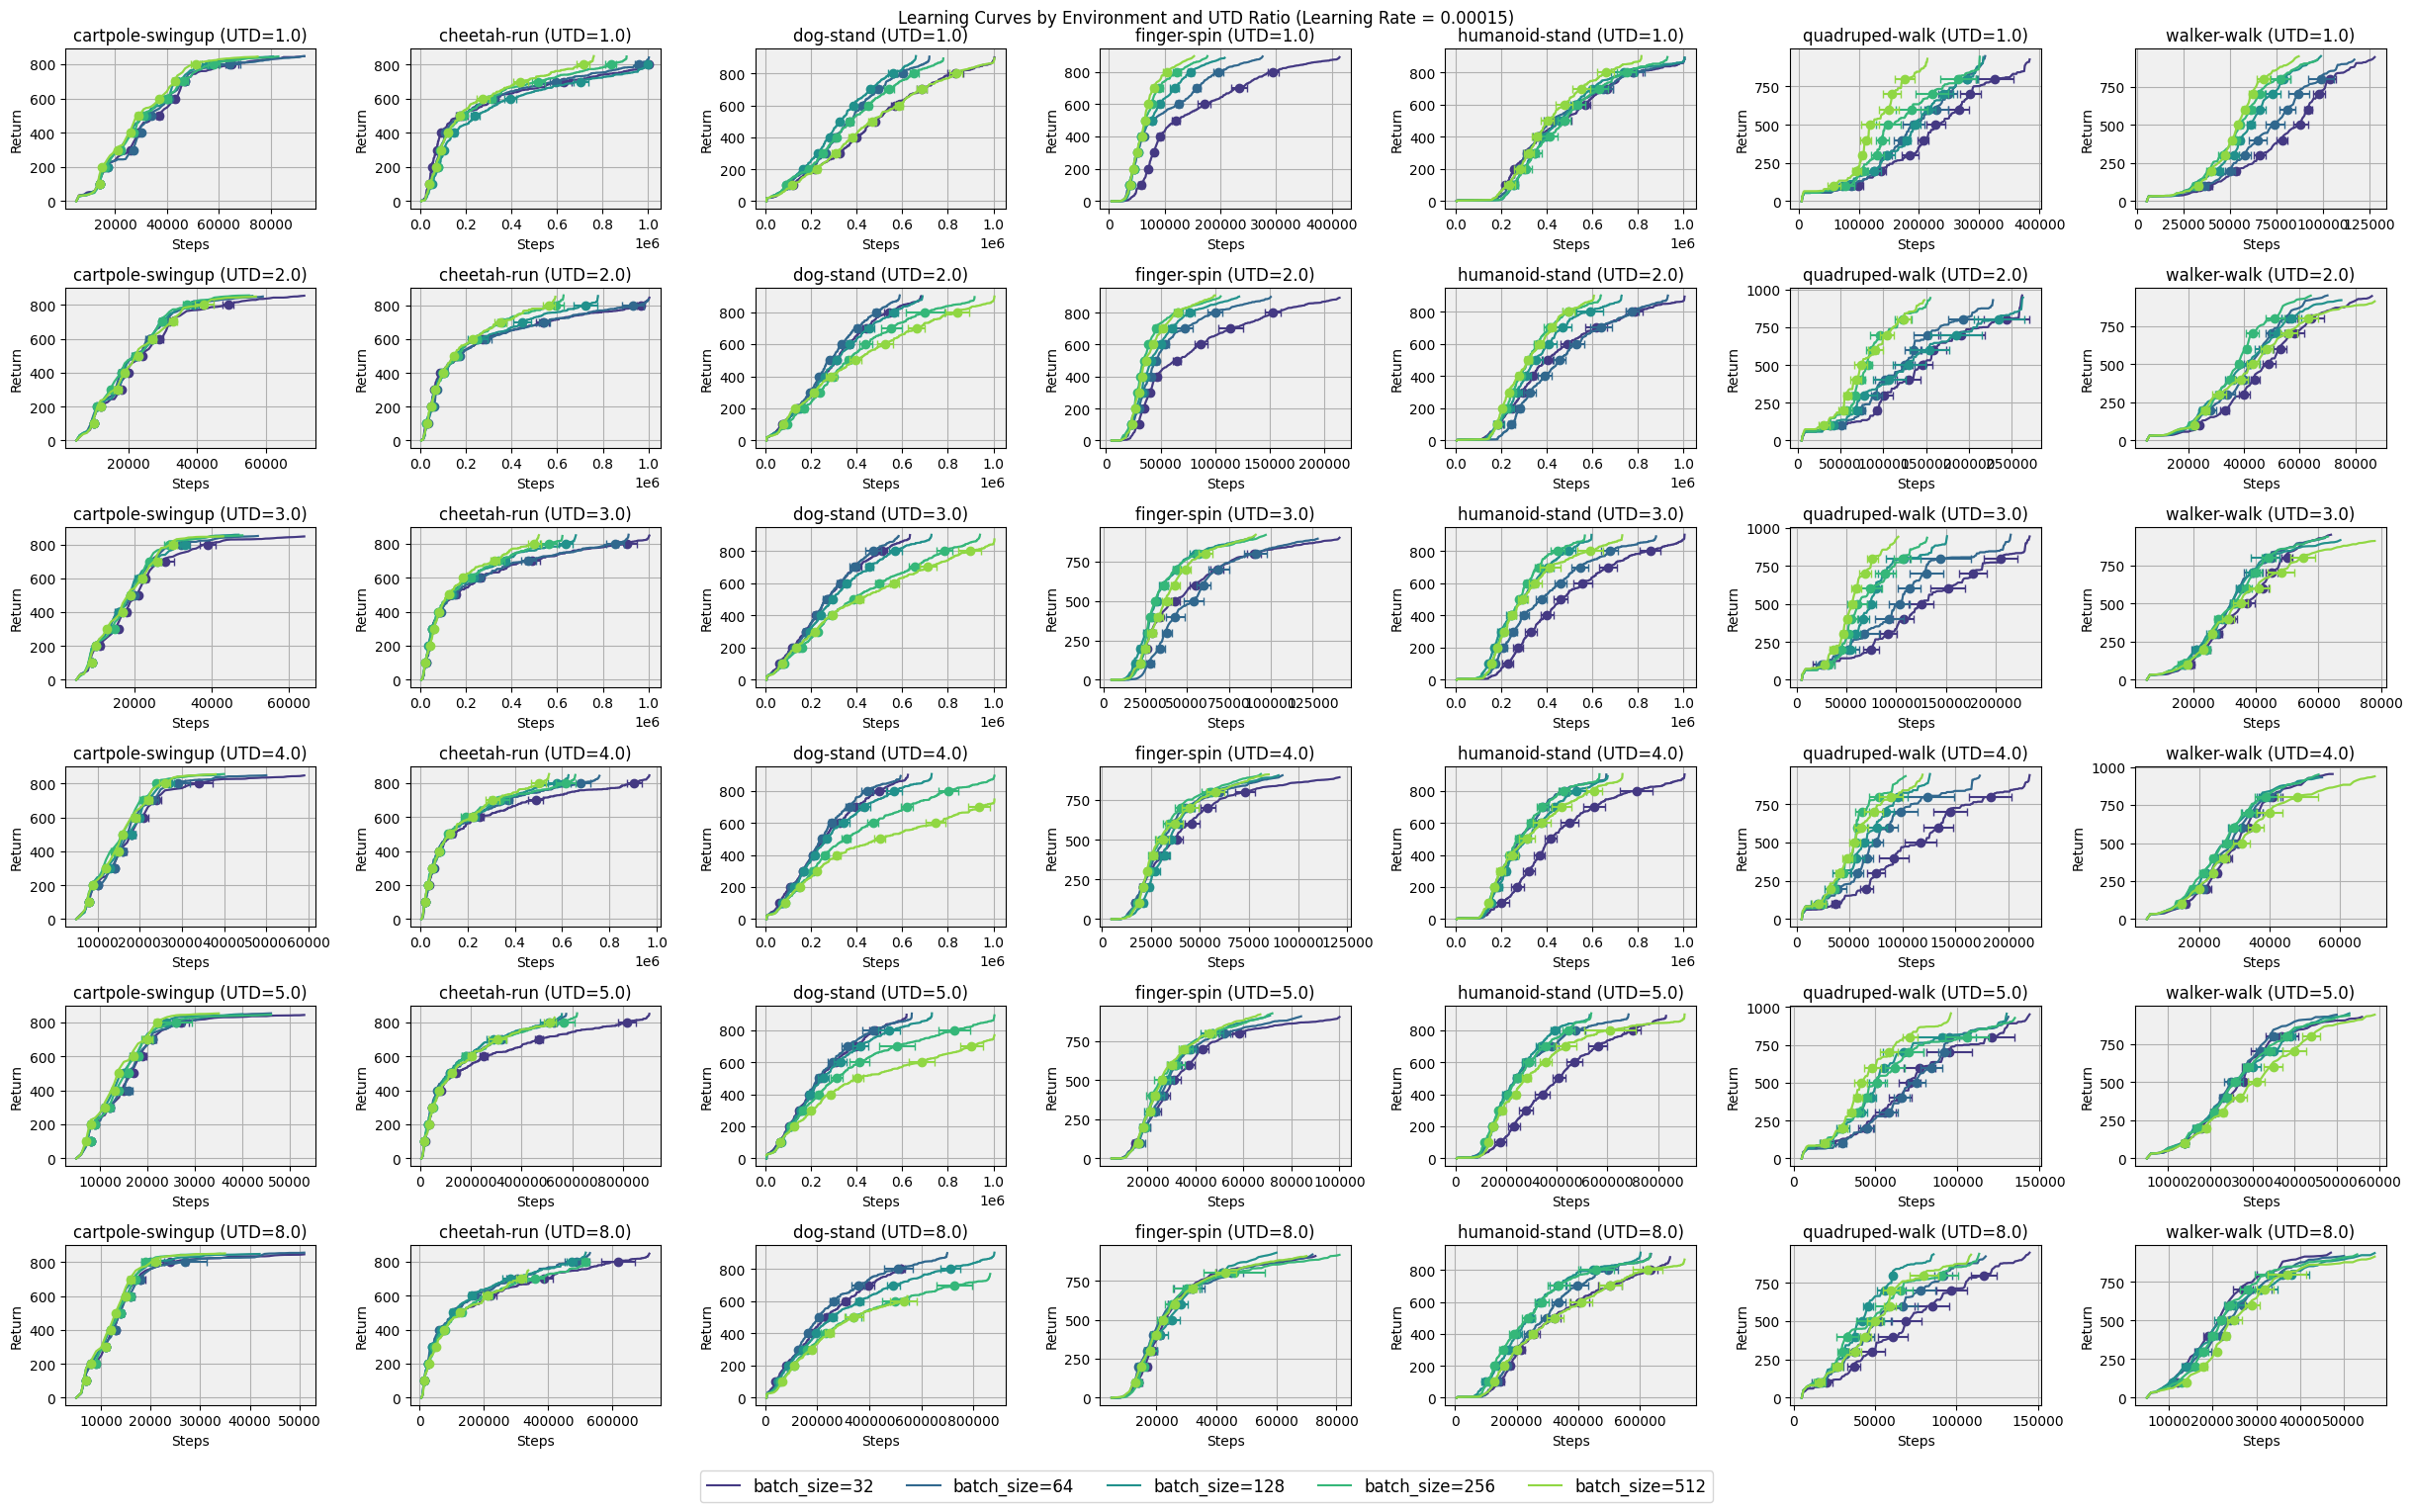

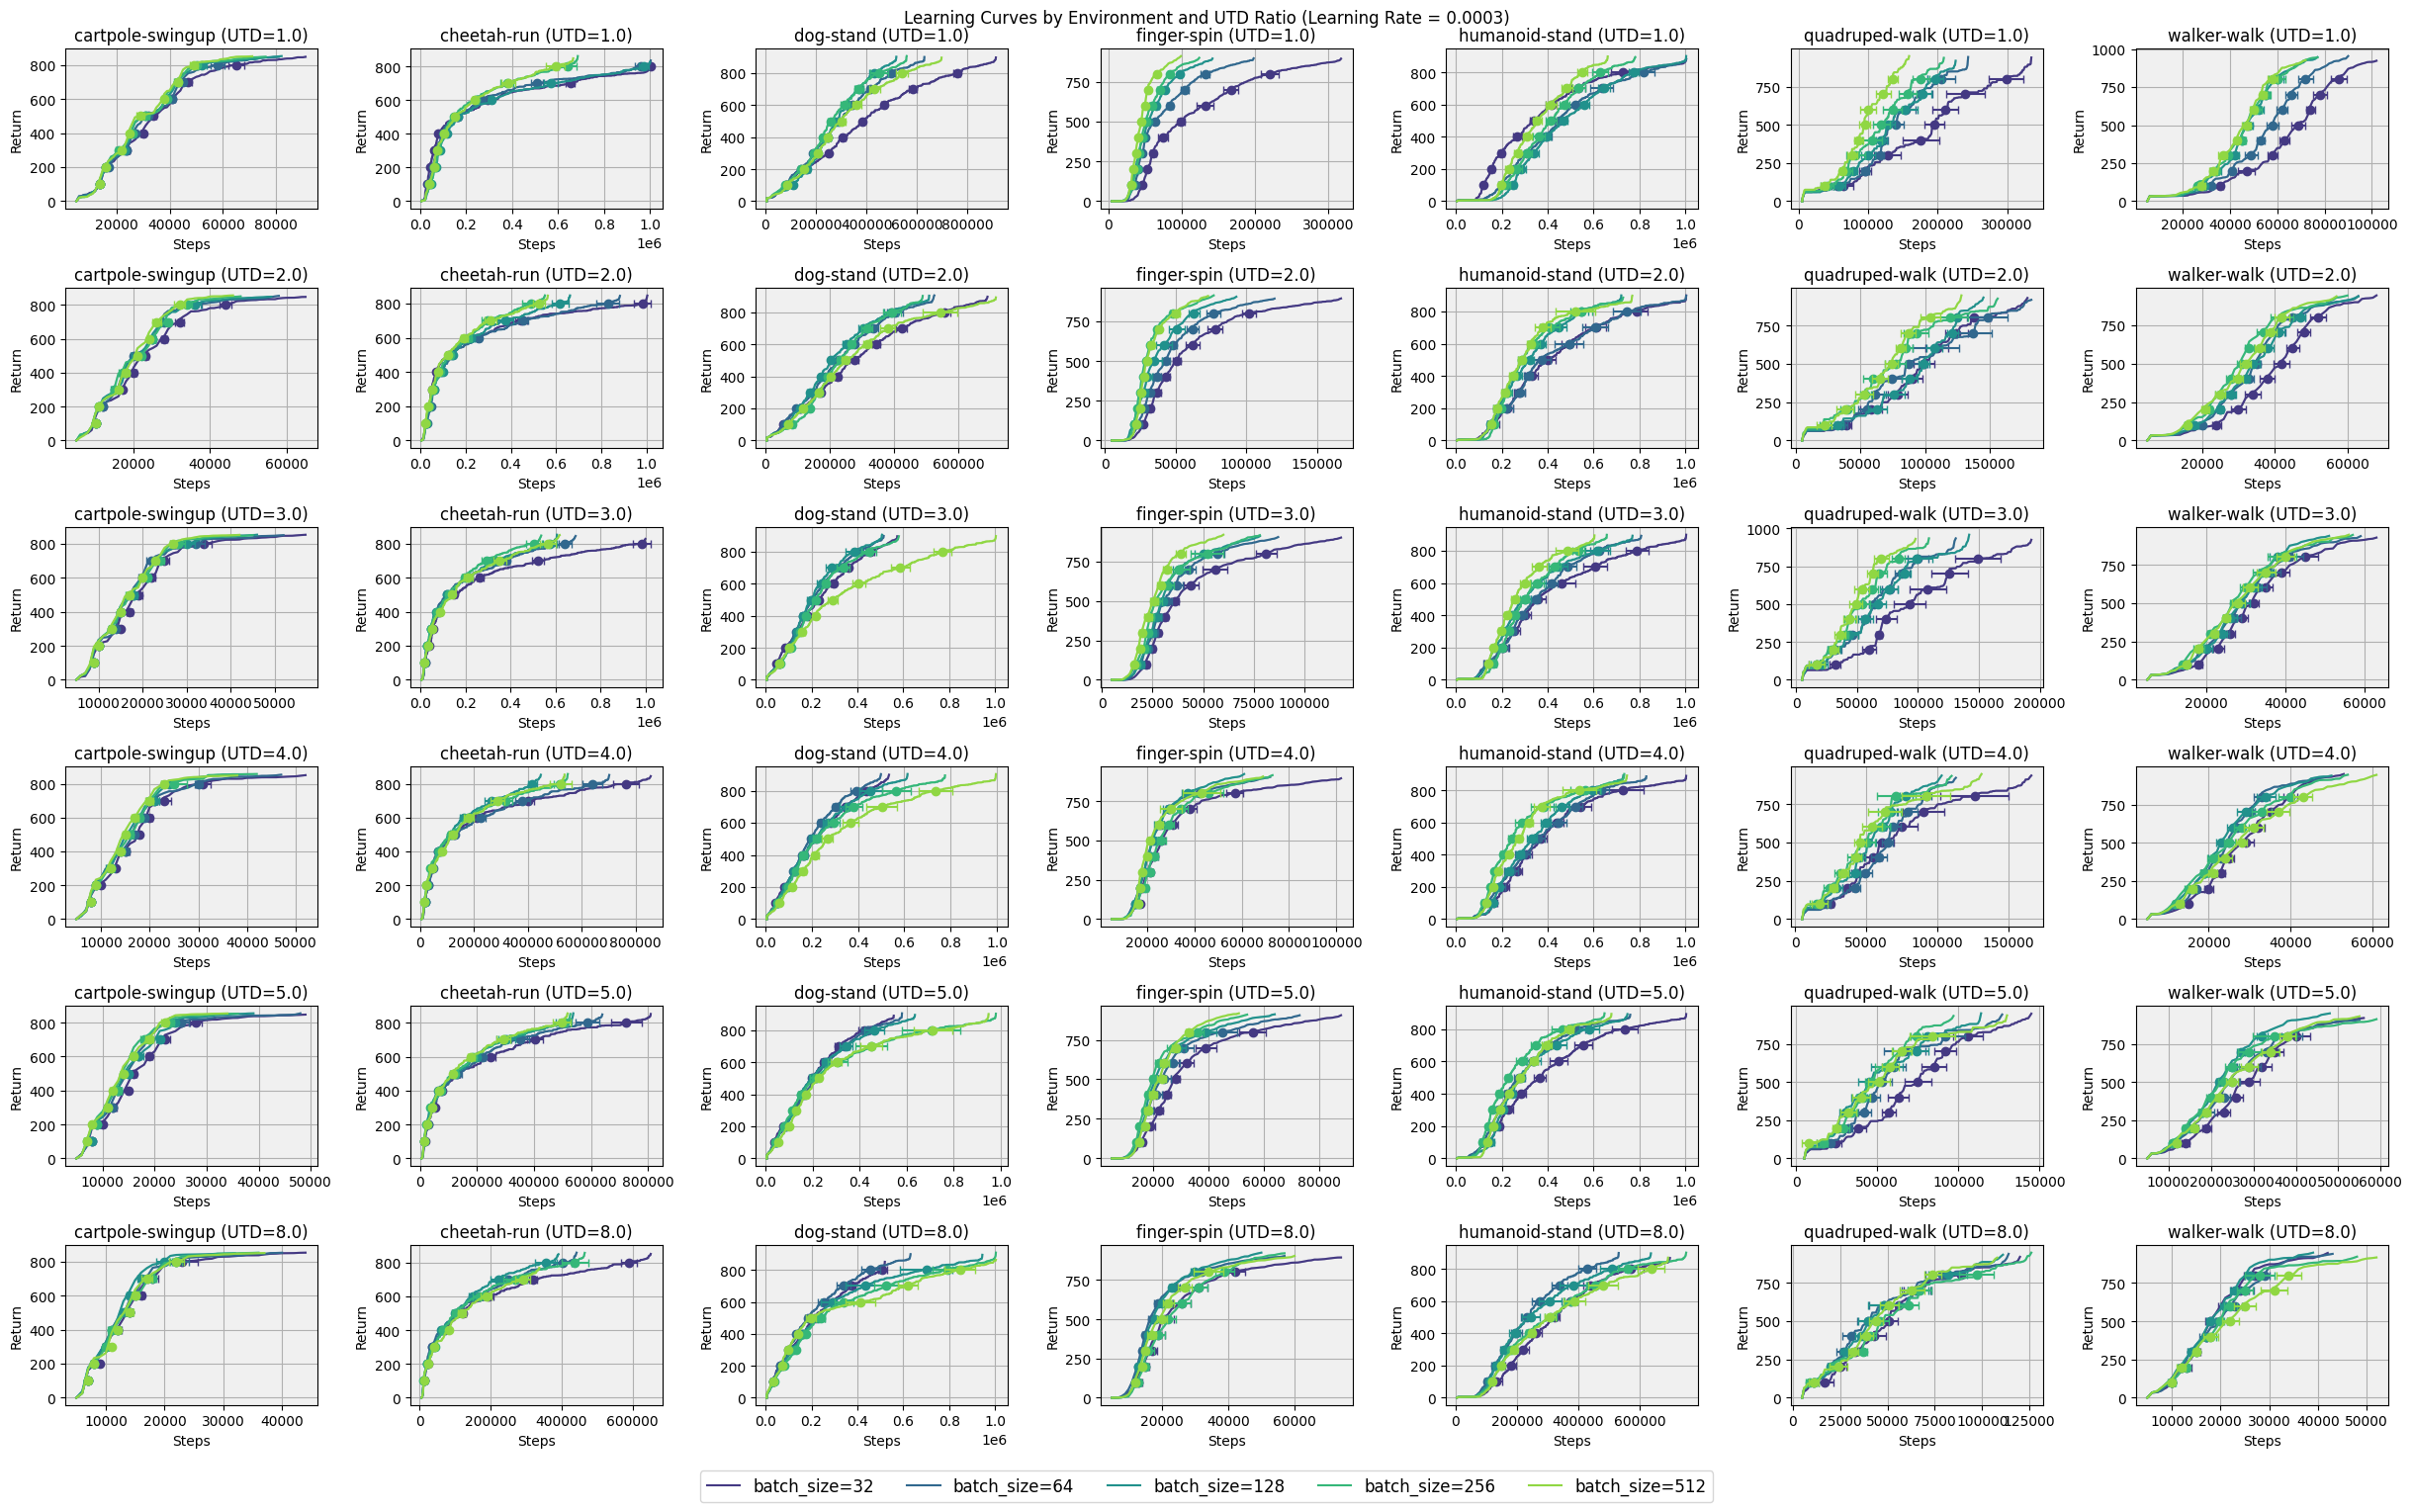

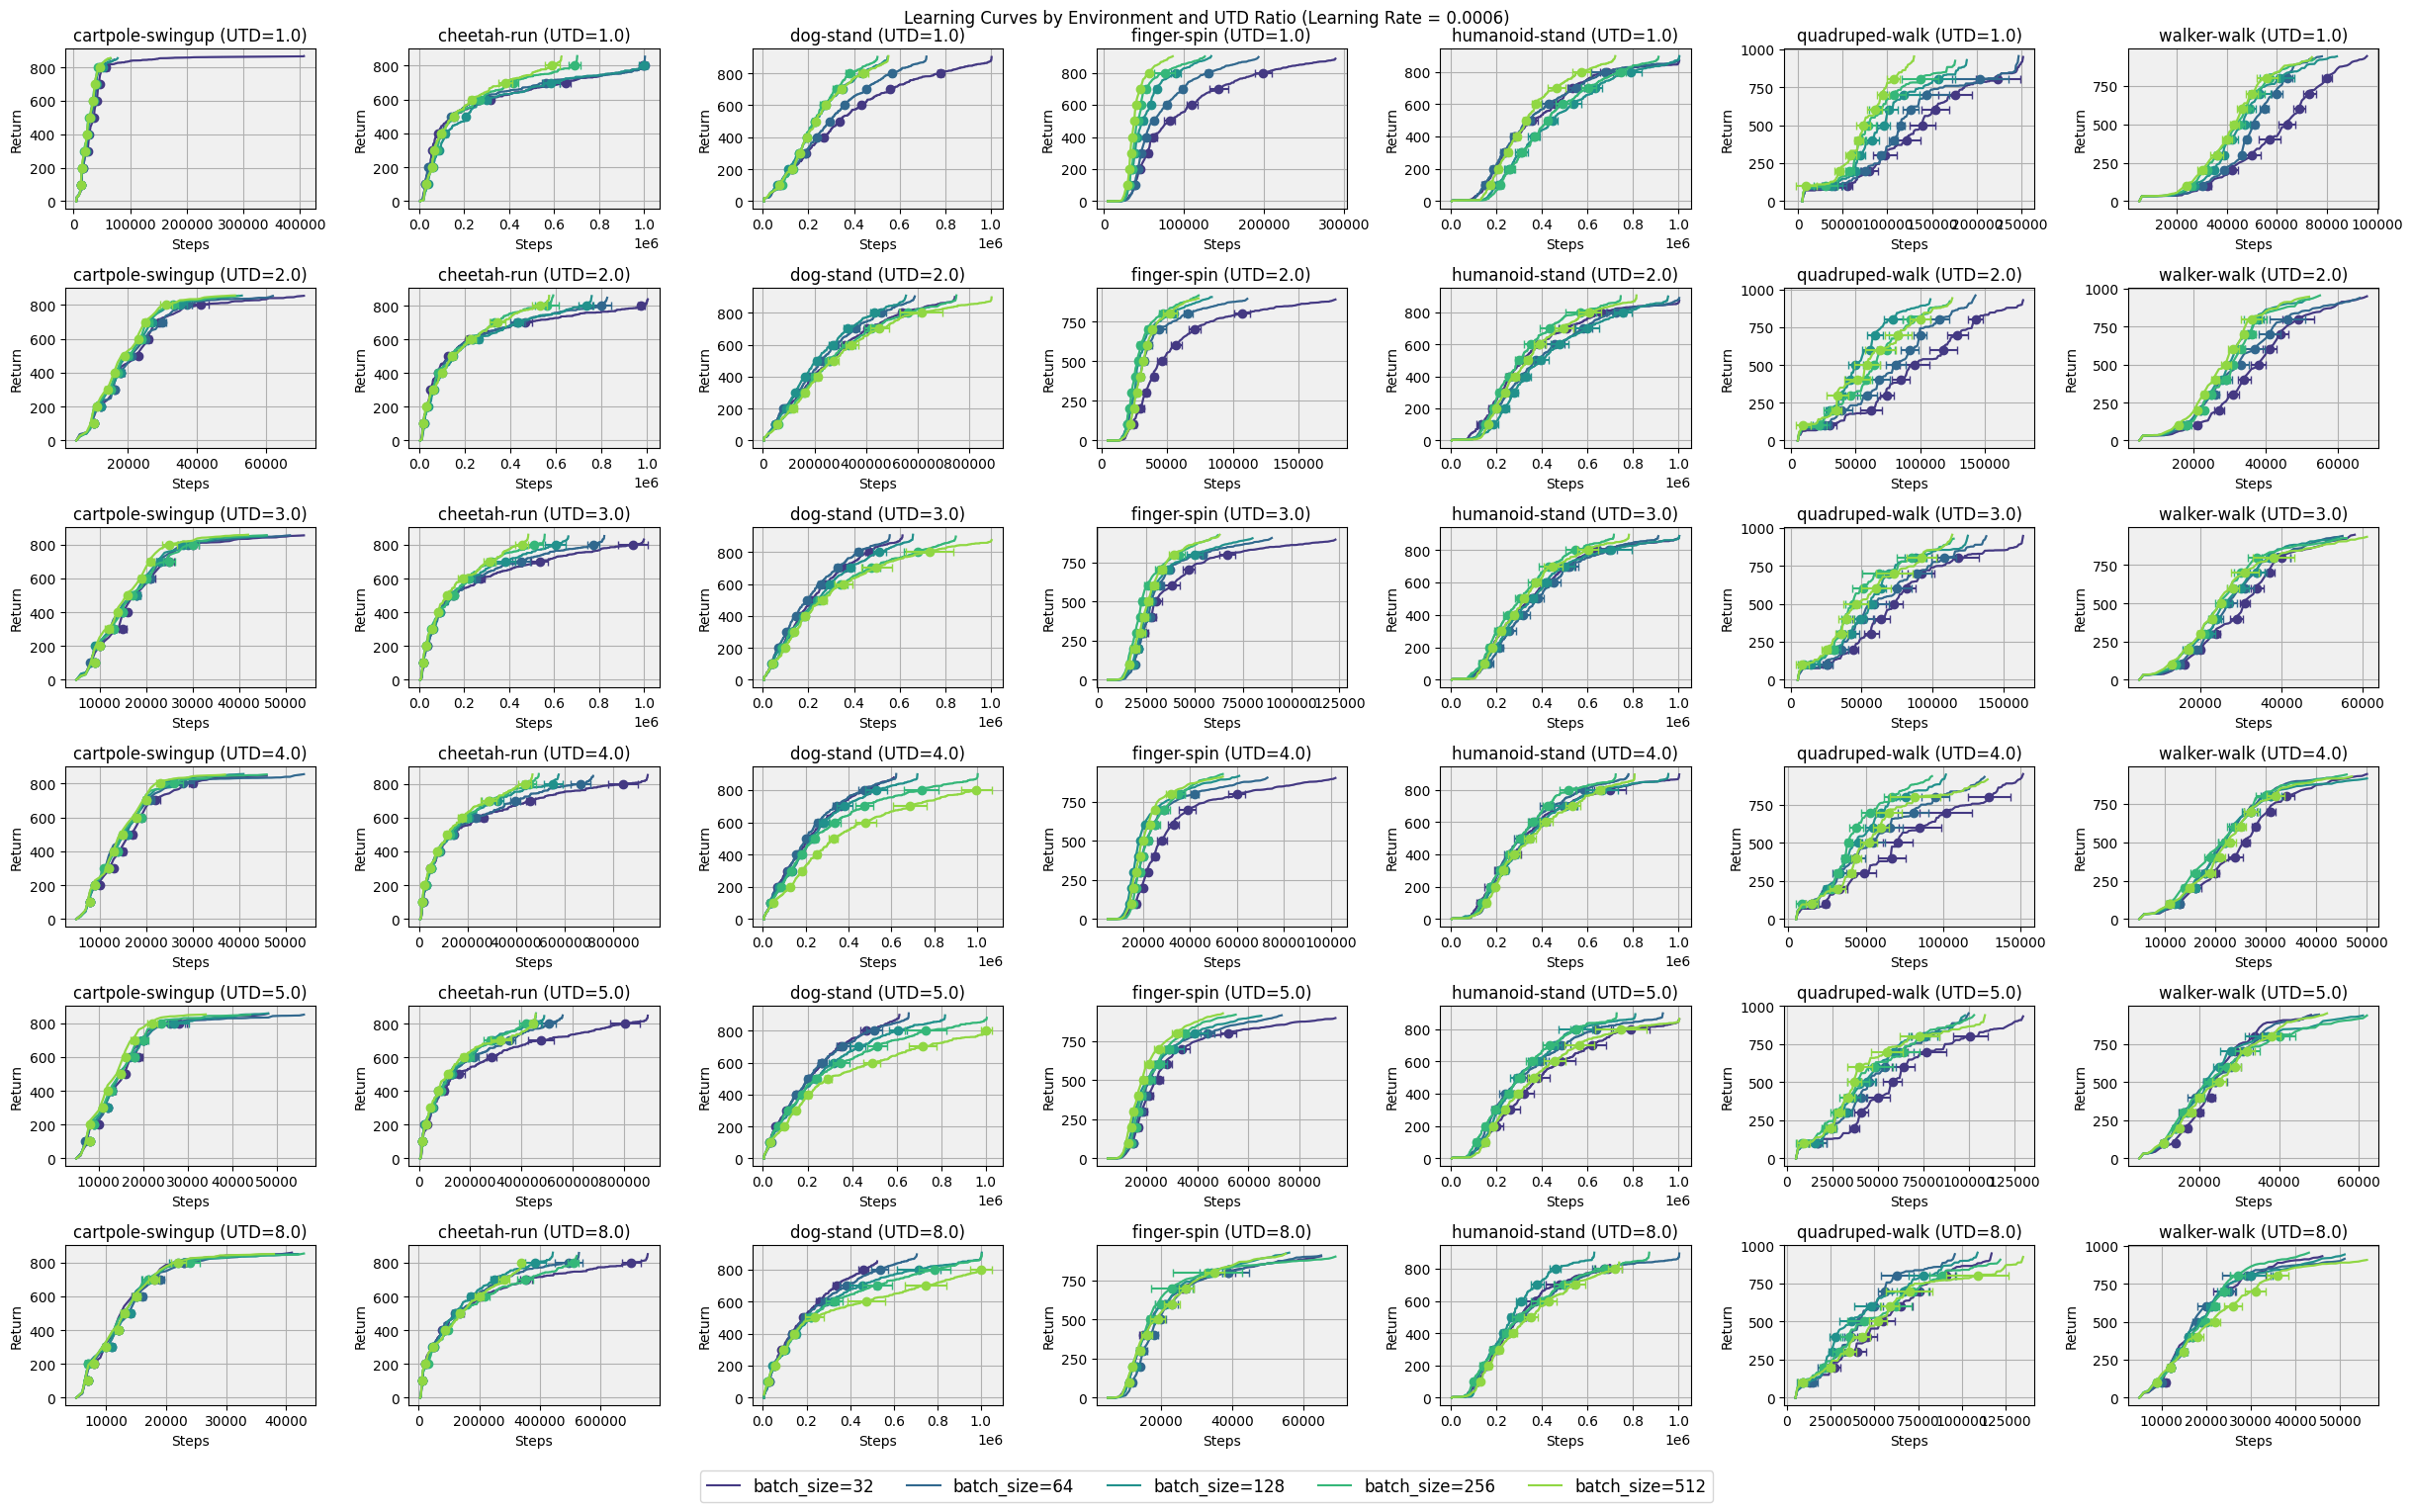

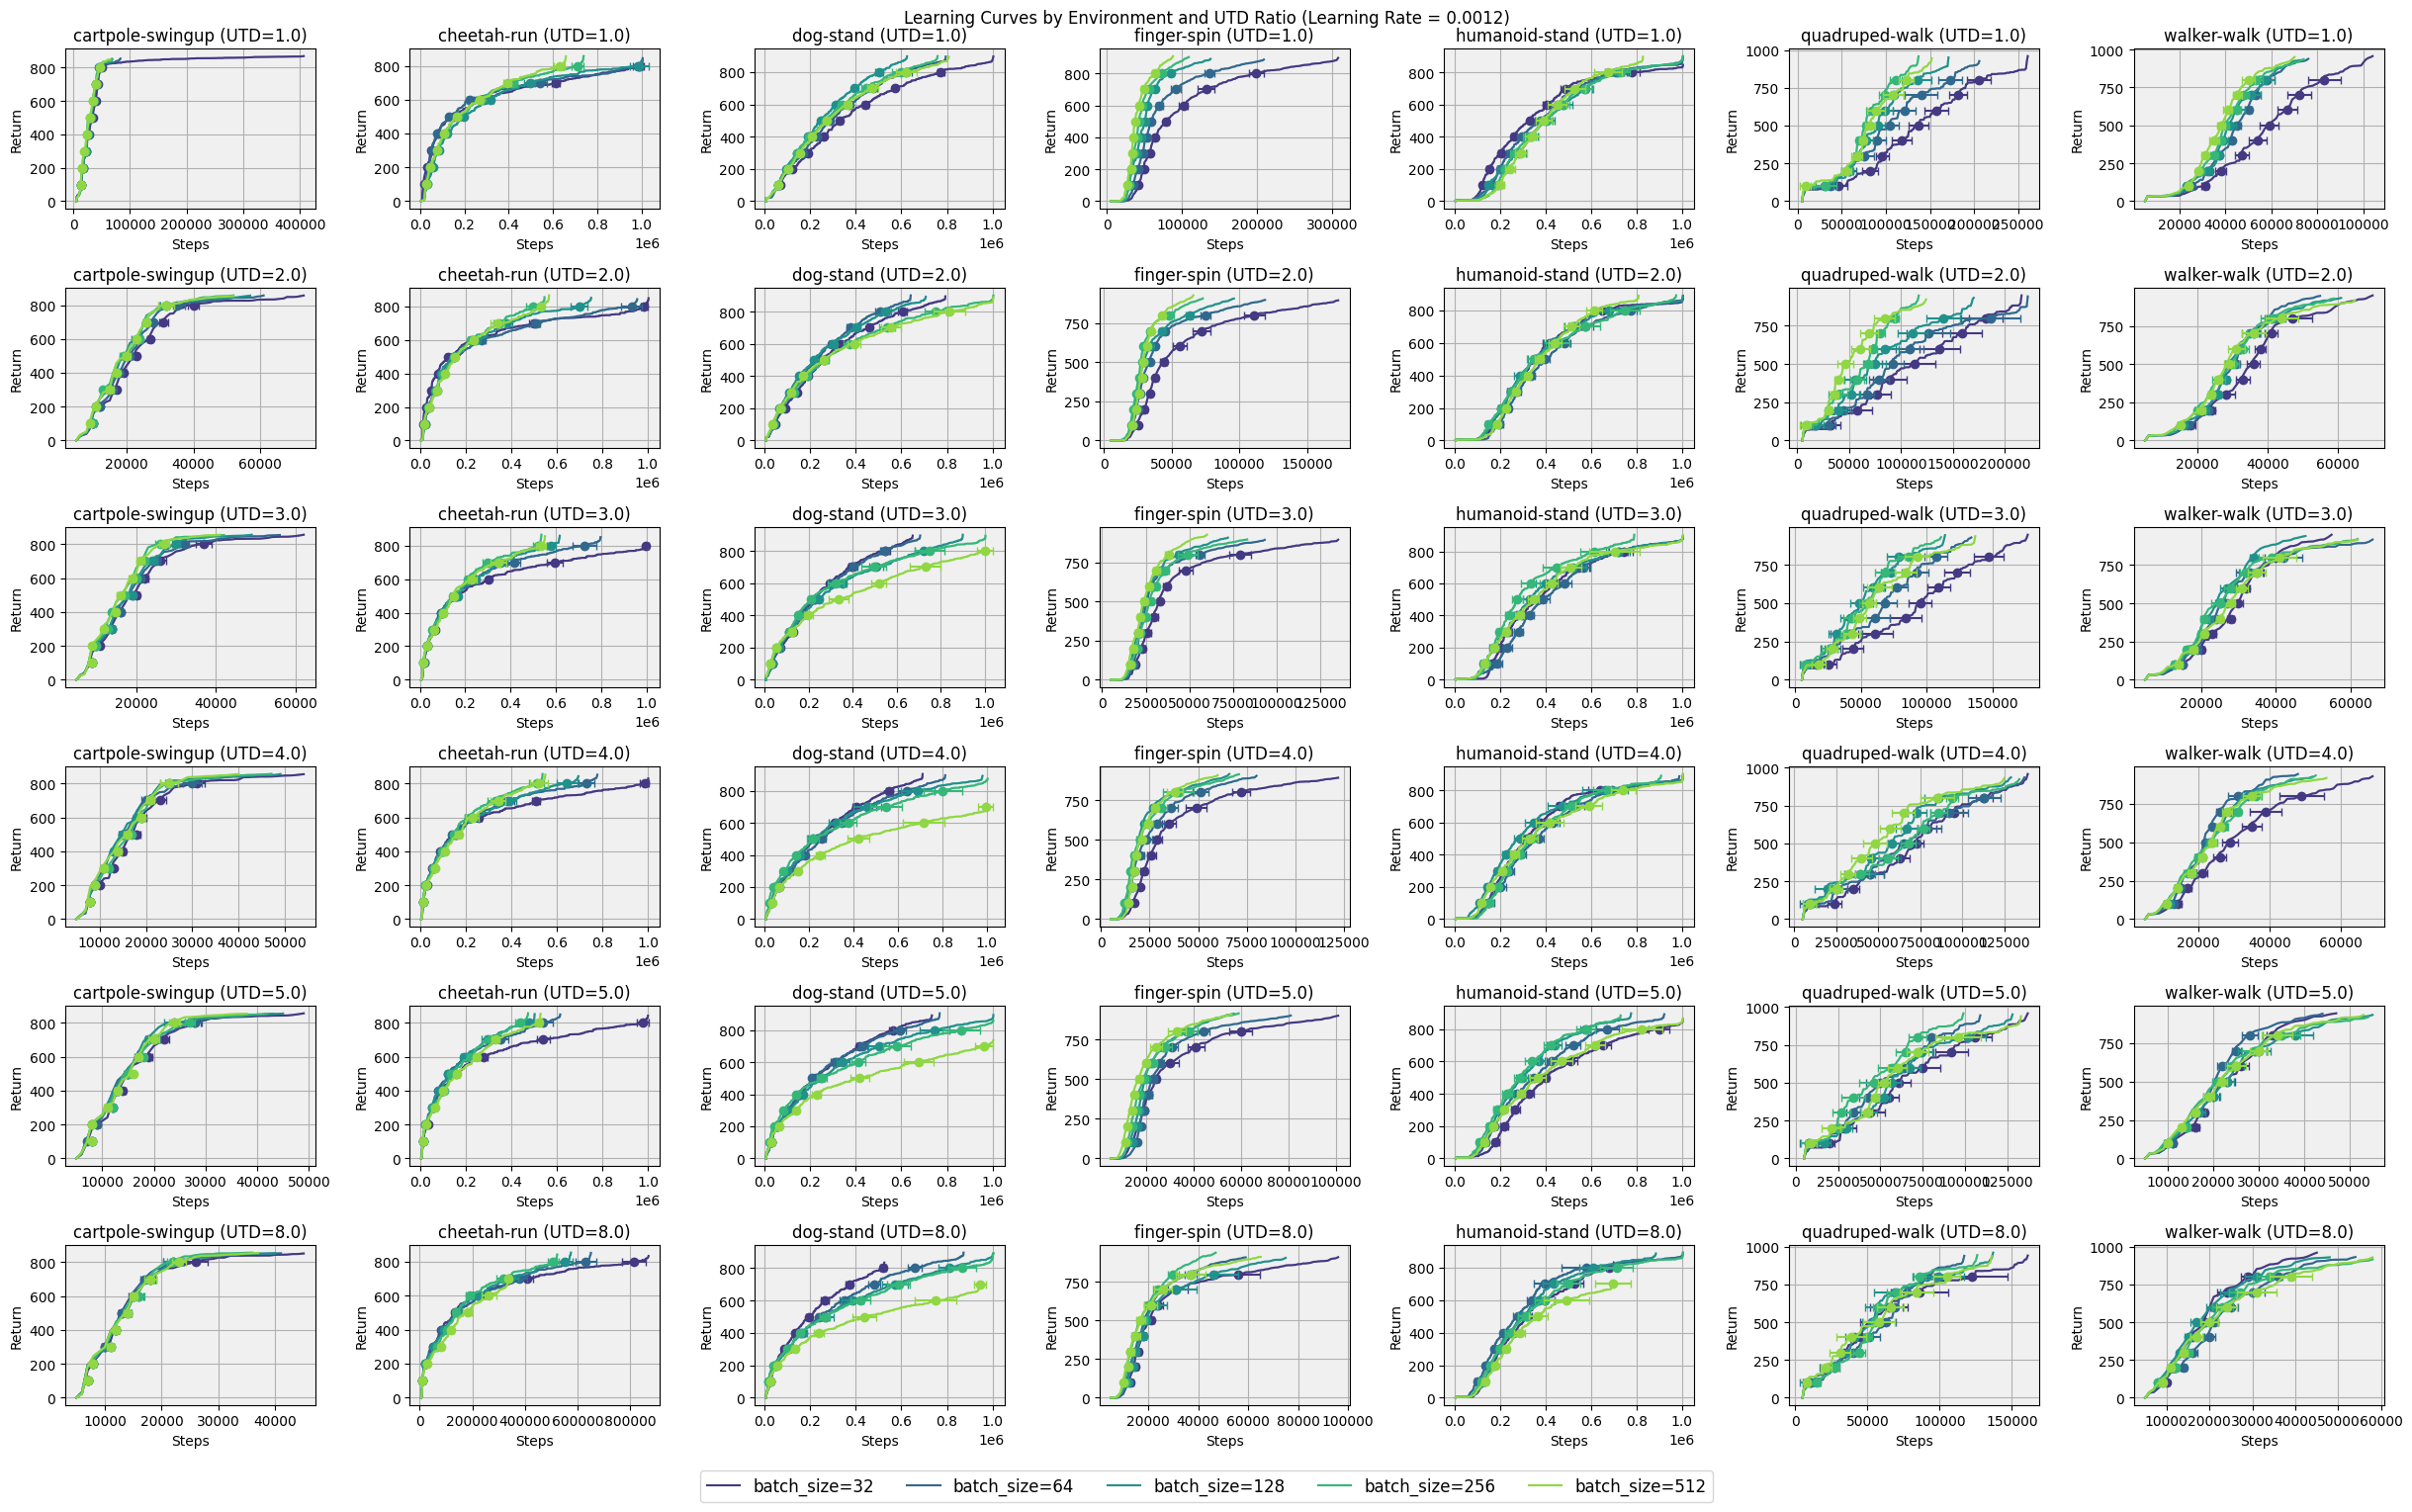

In [5]:
learning_curves.plot_per_learning_rate(grid_search_df, config.thresholds)

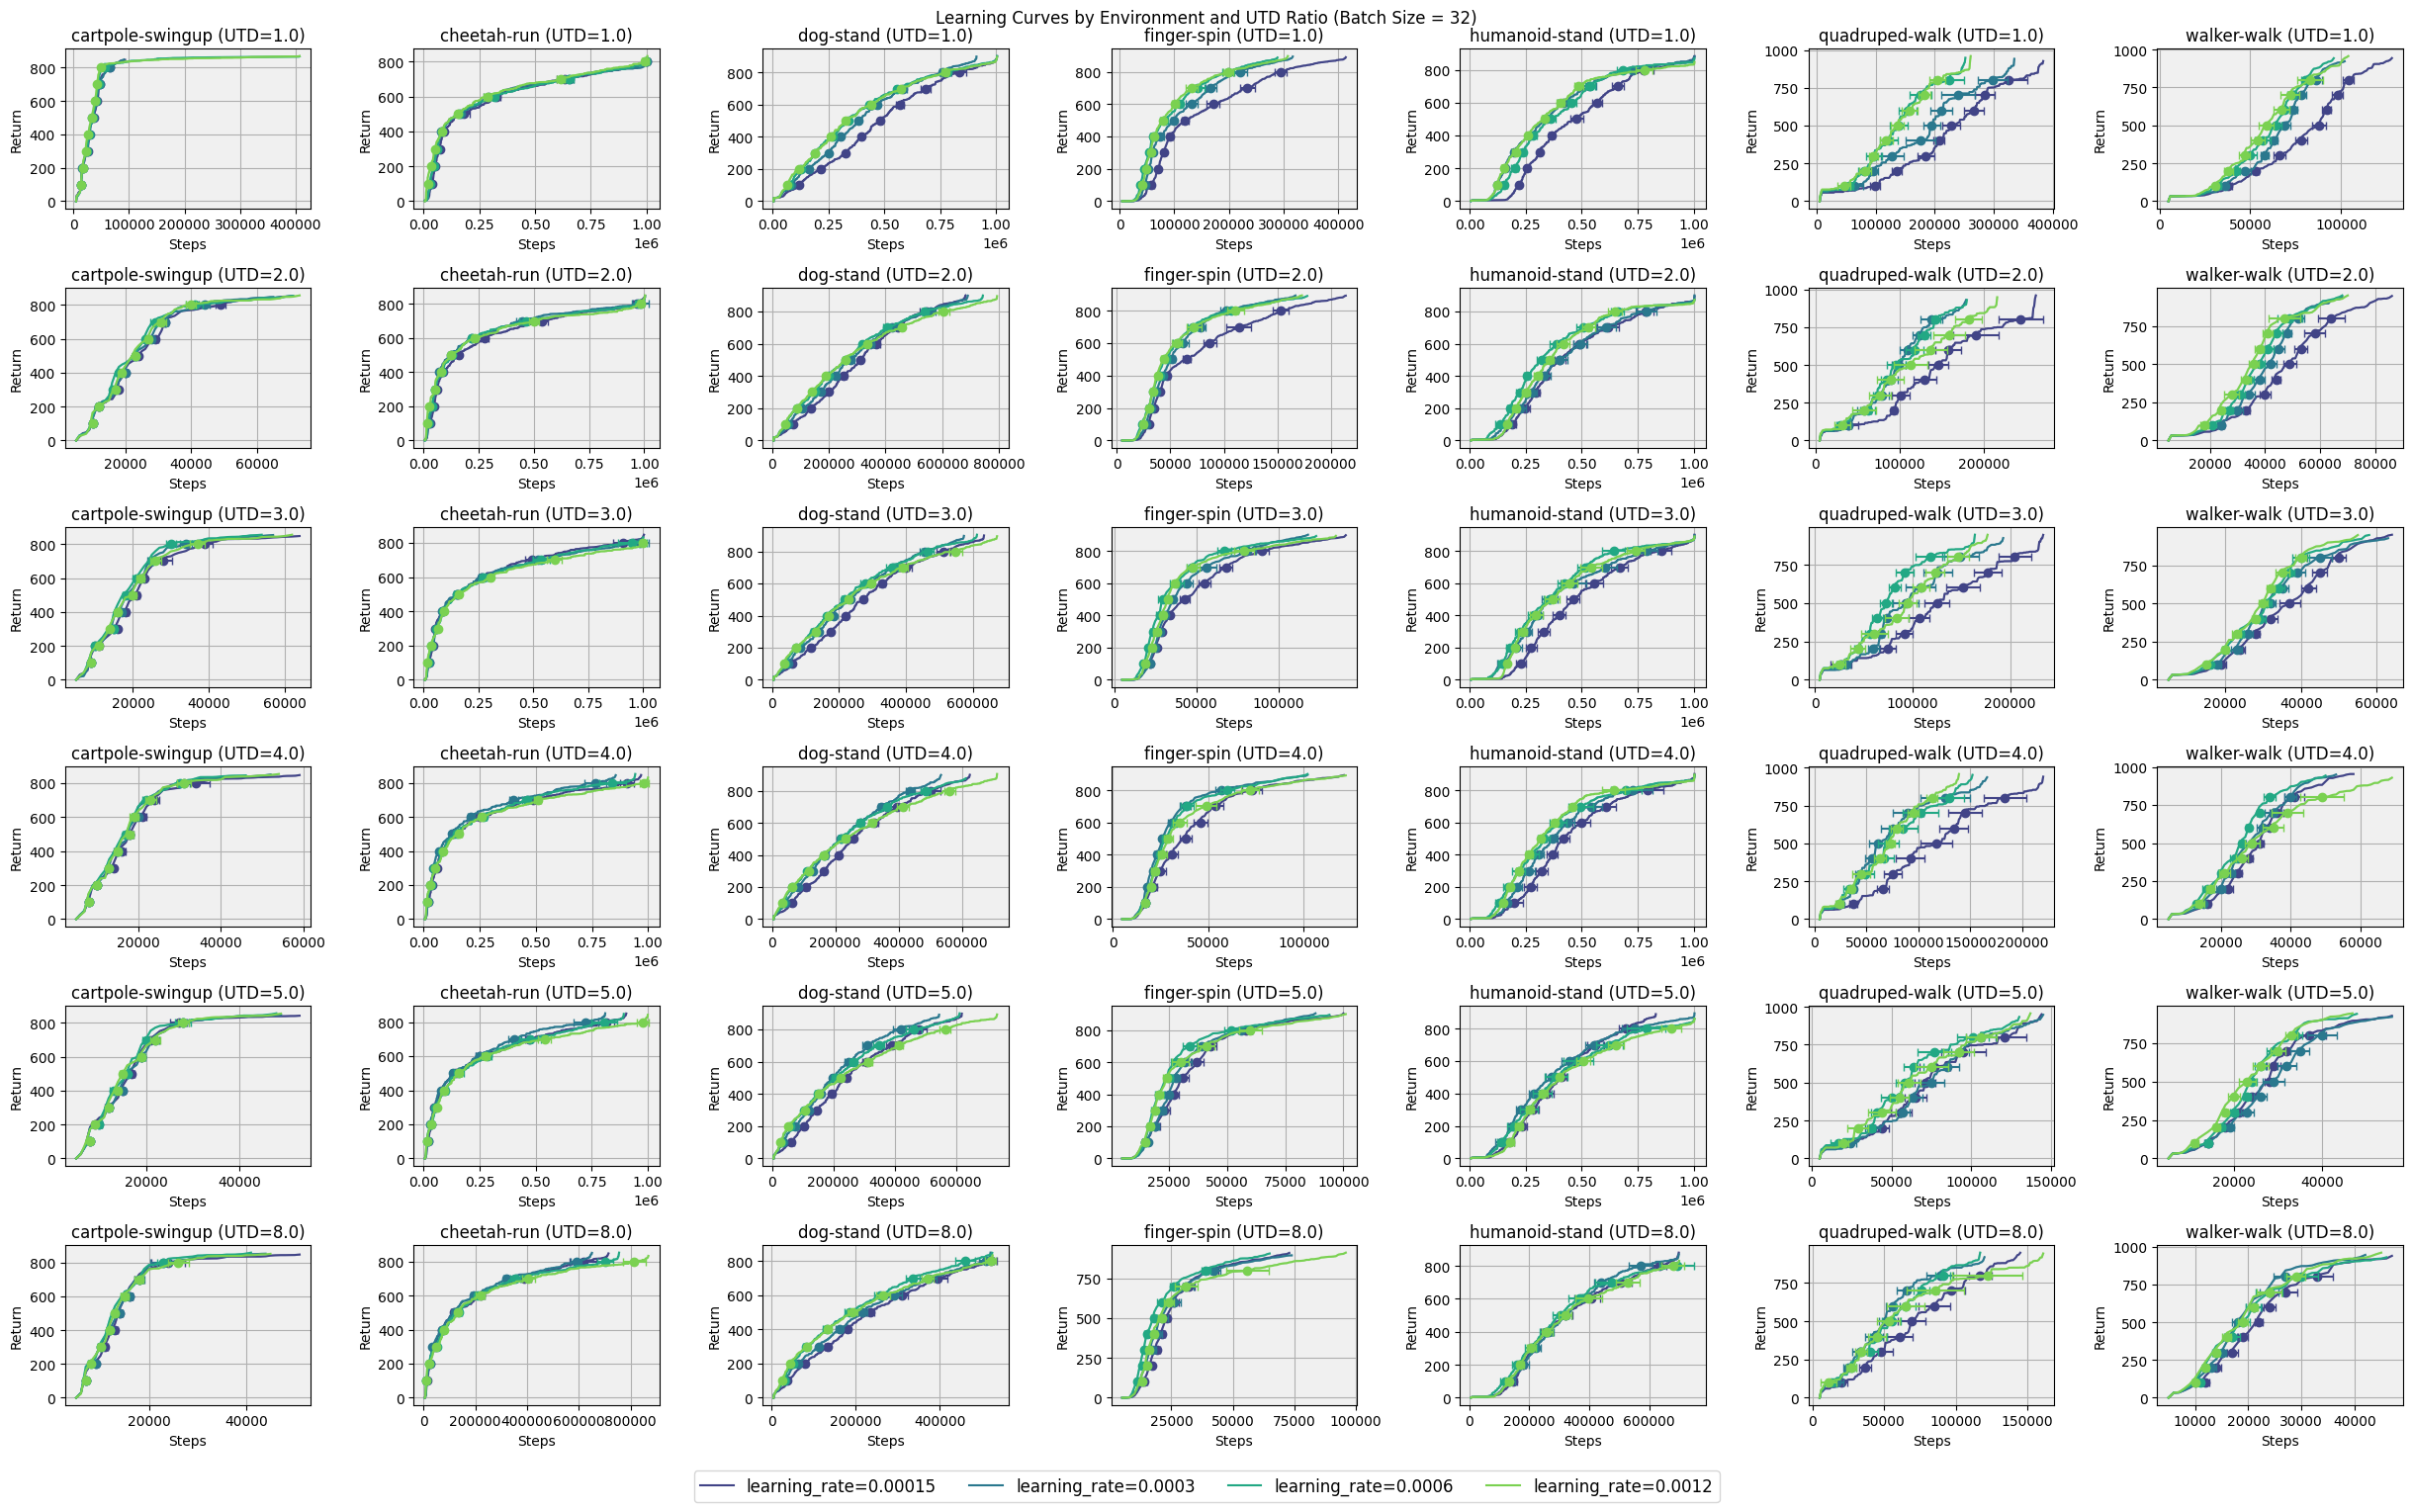

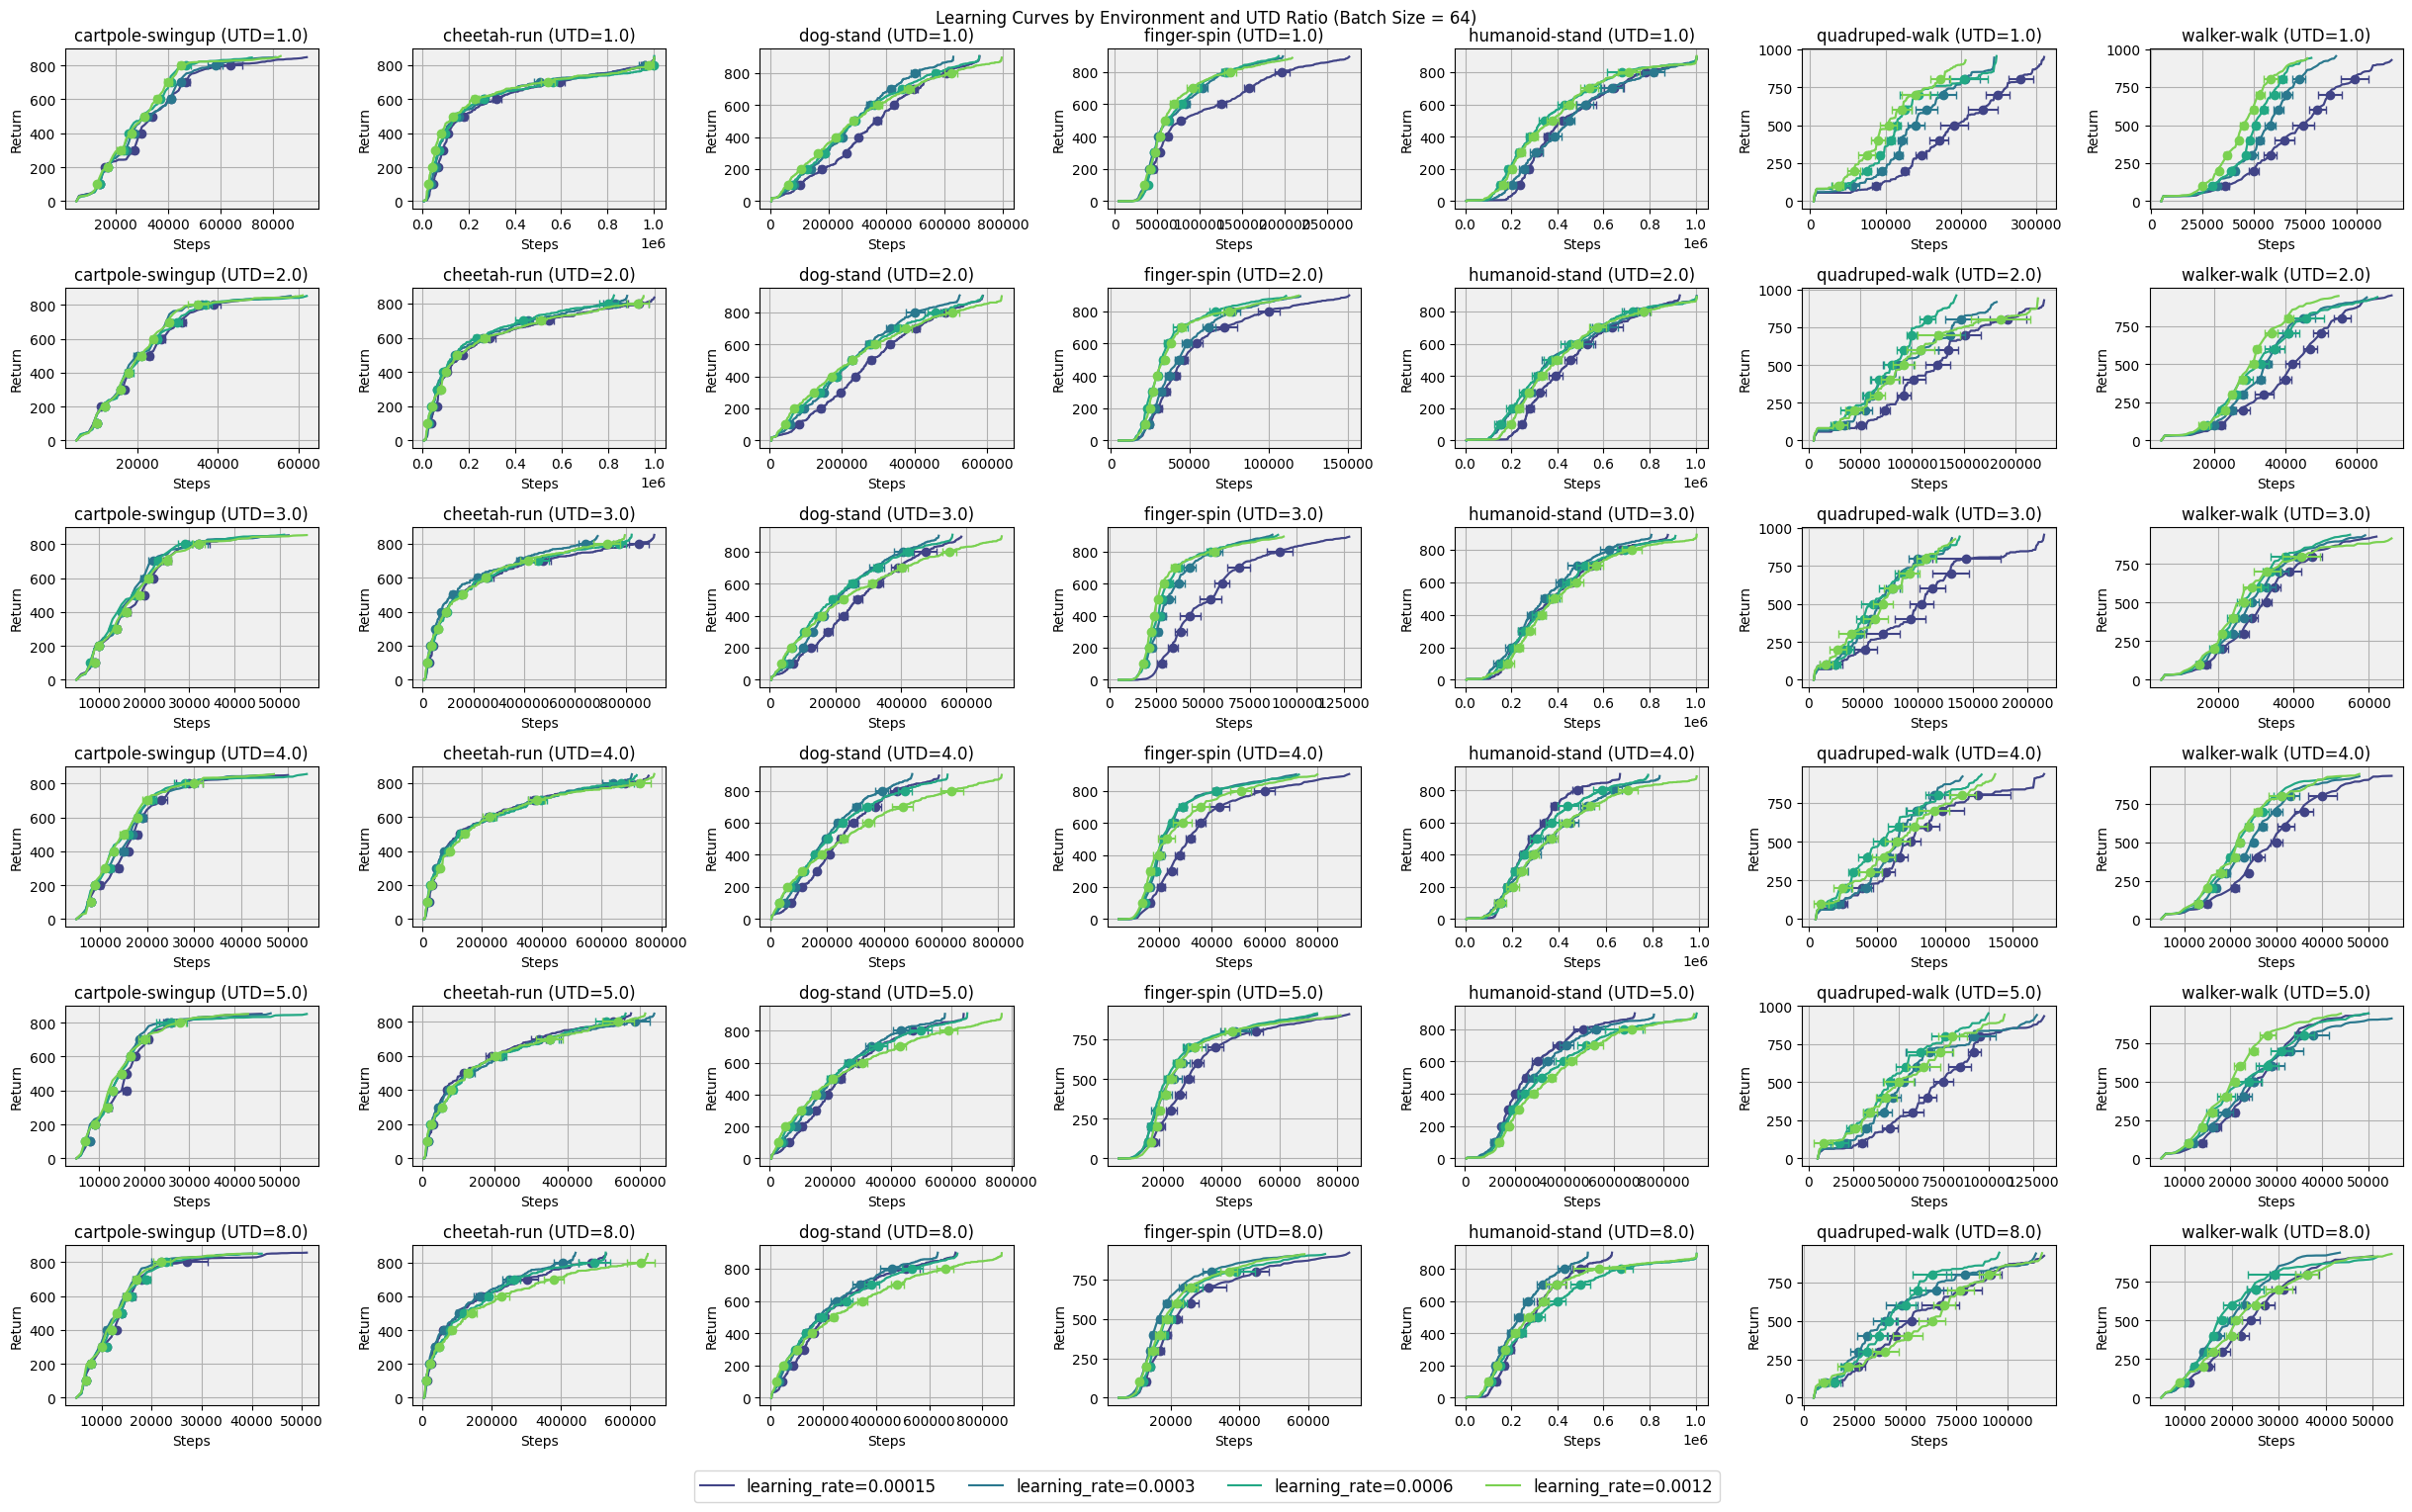

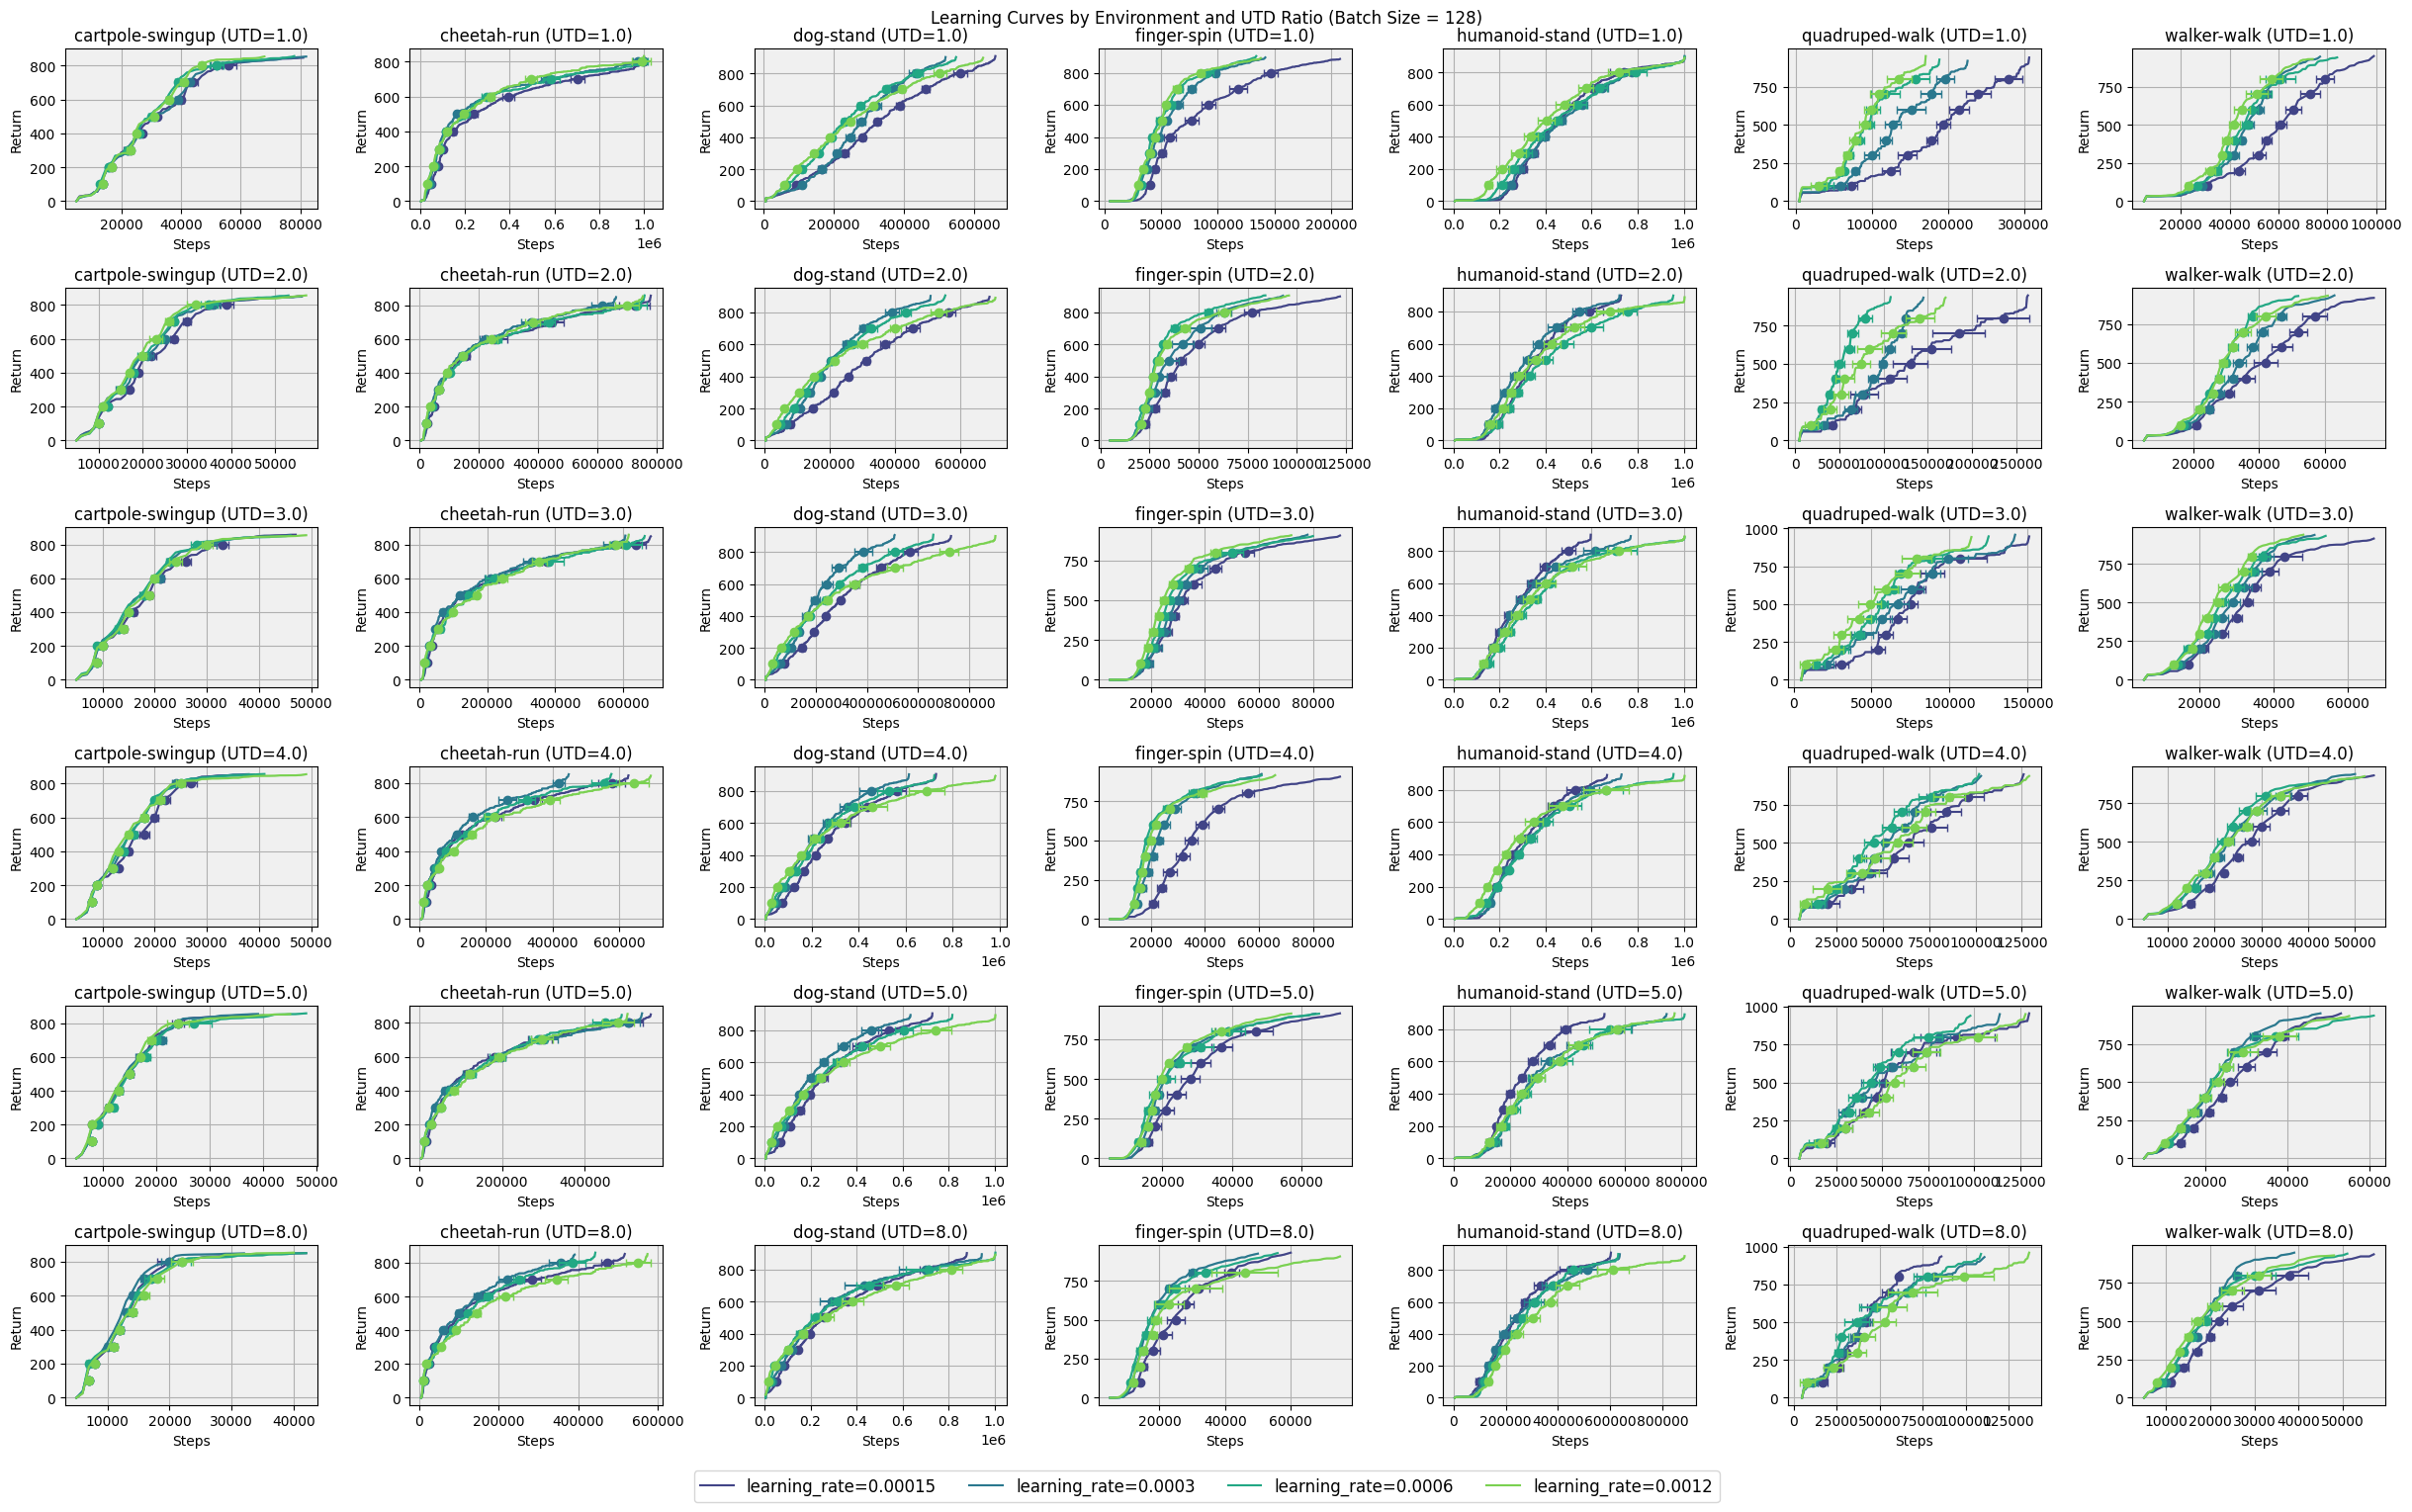

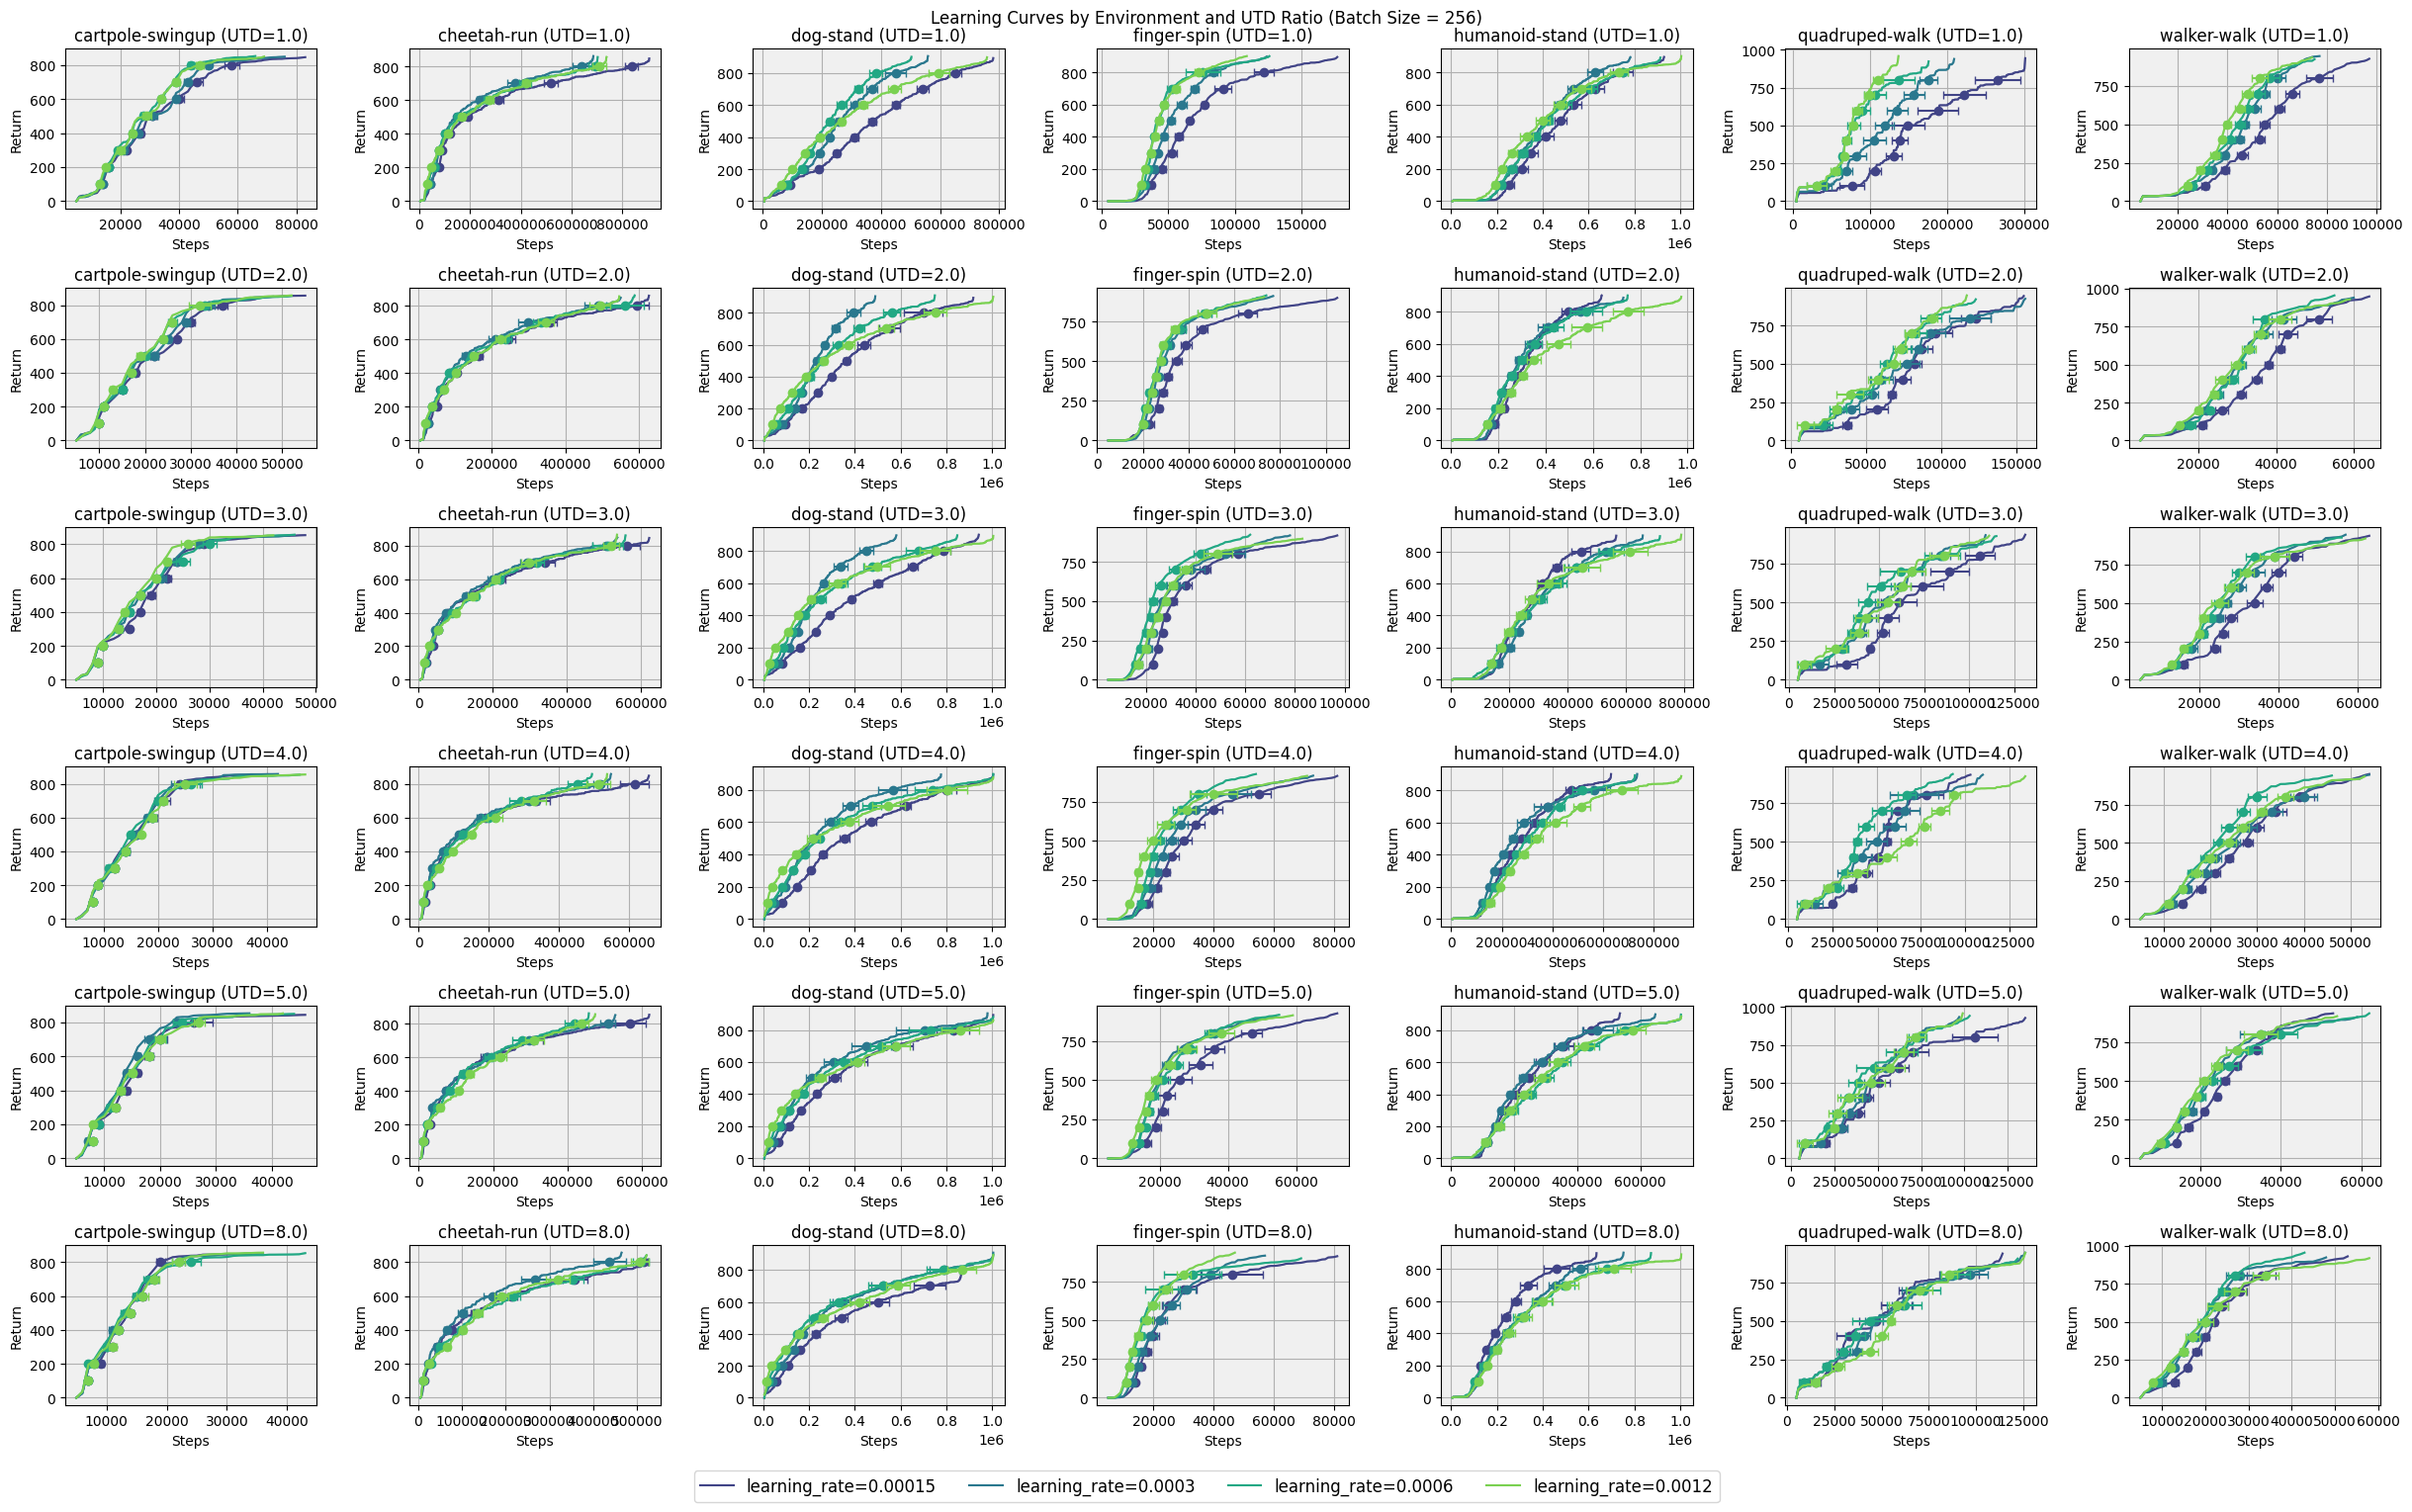

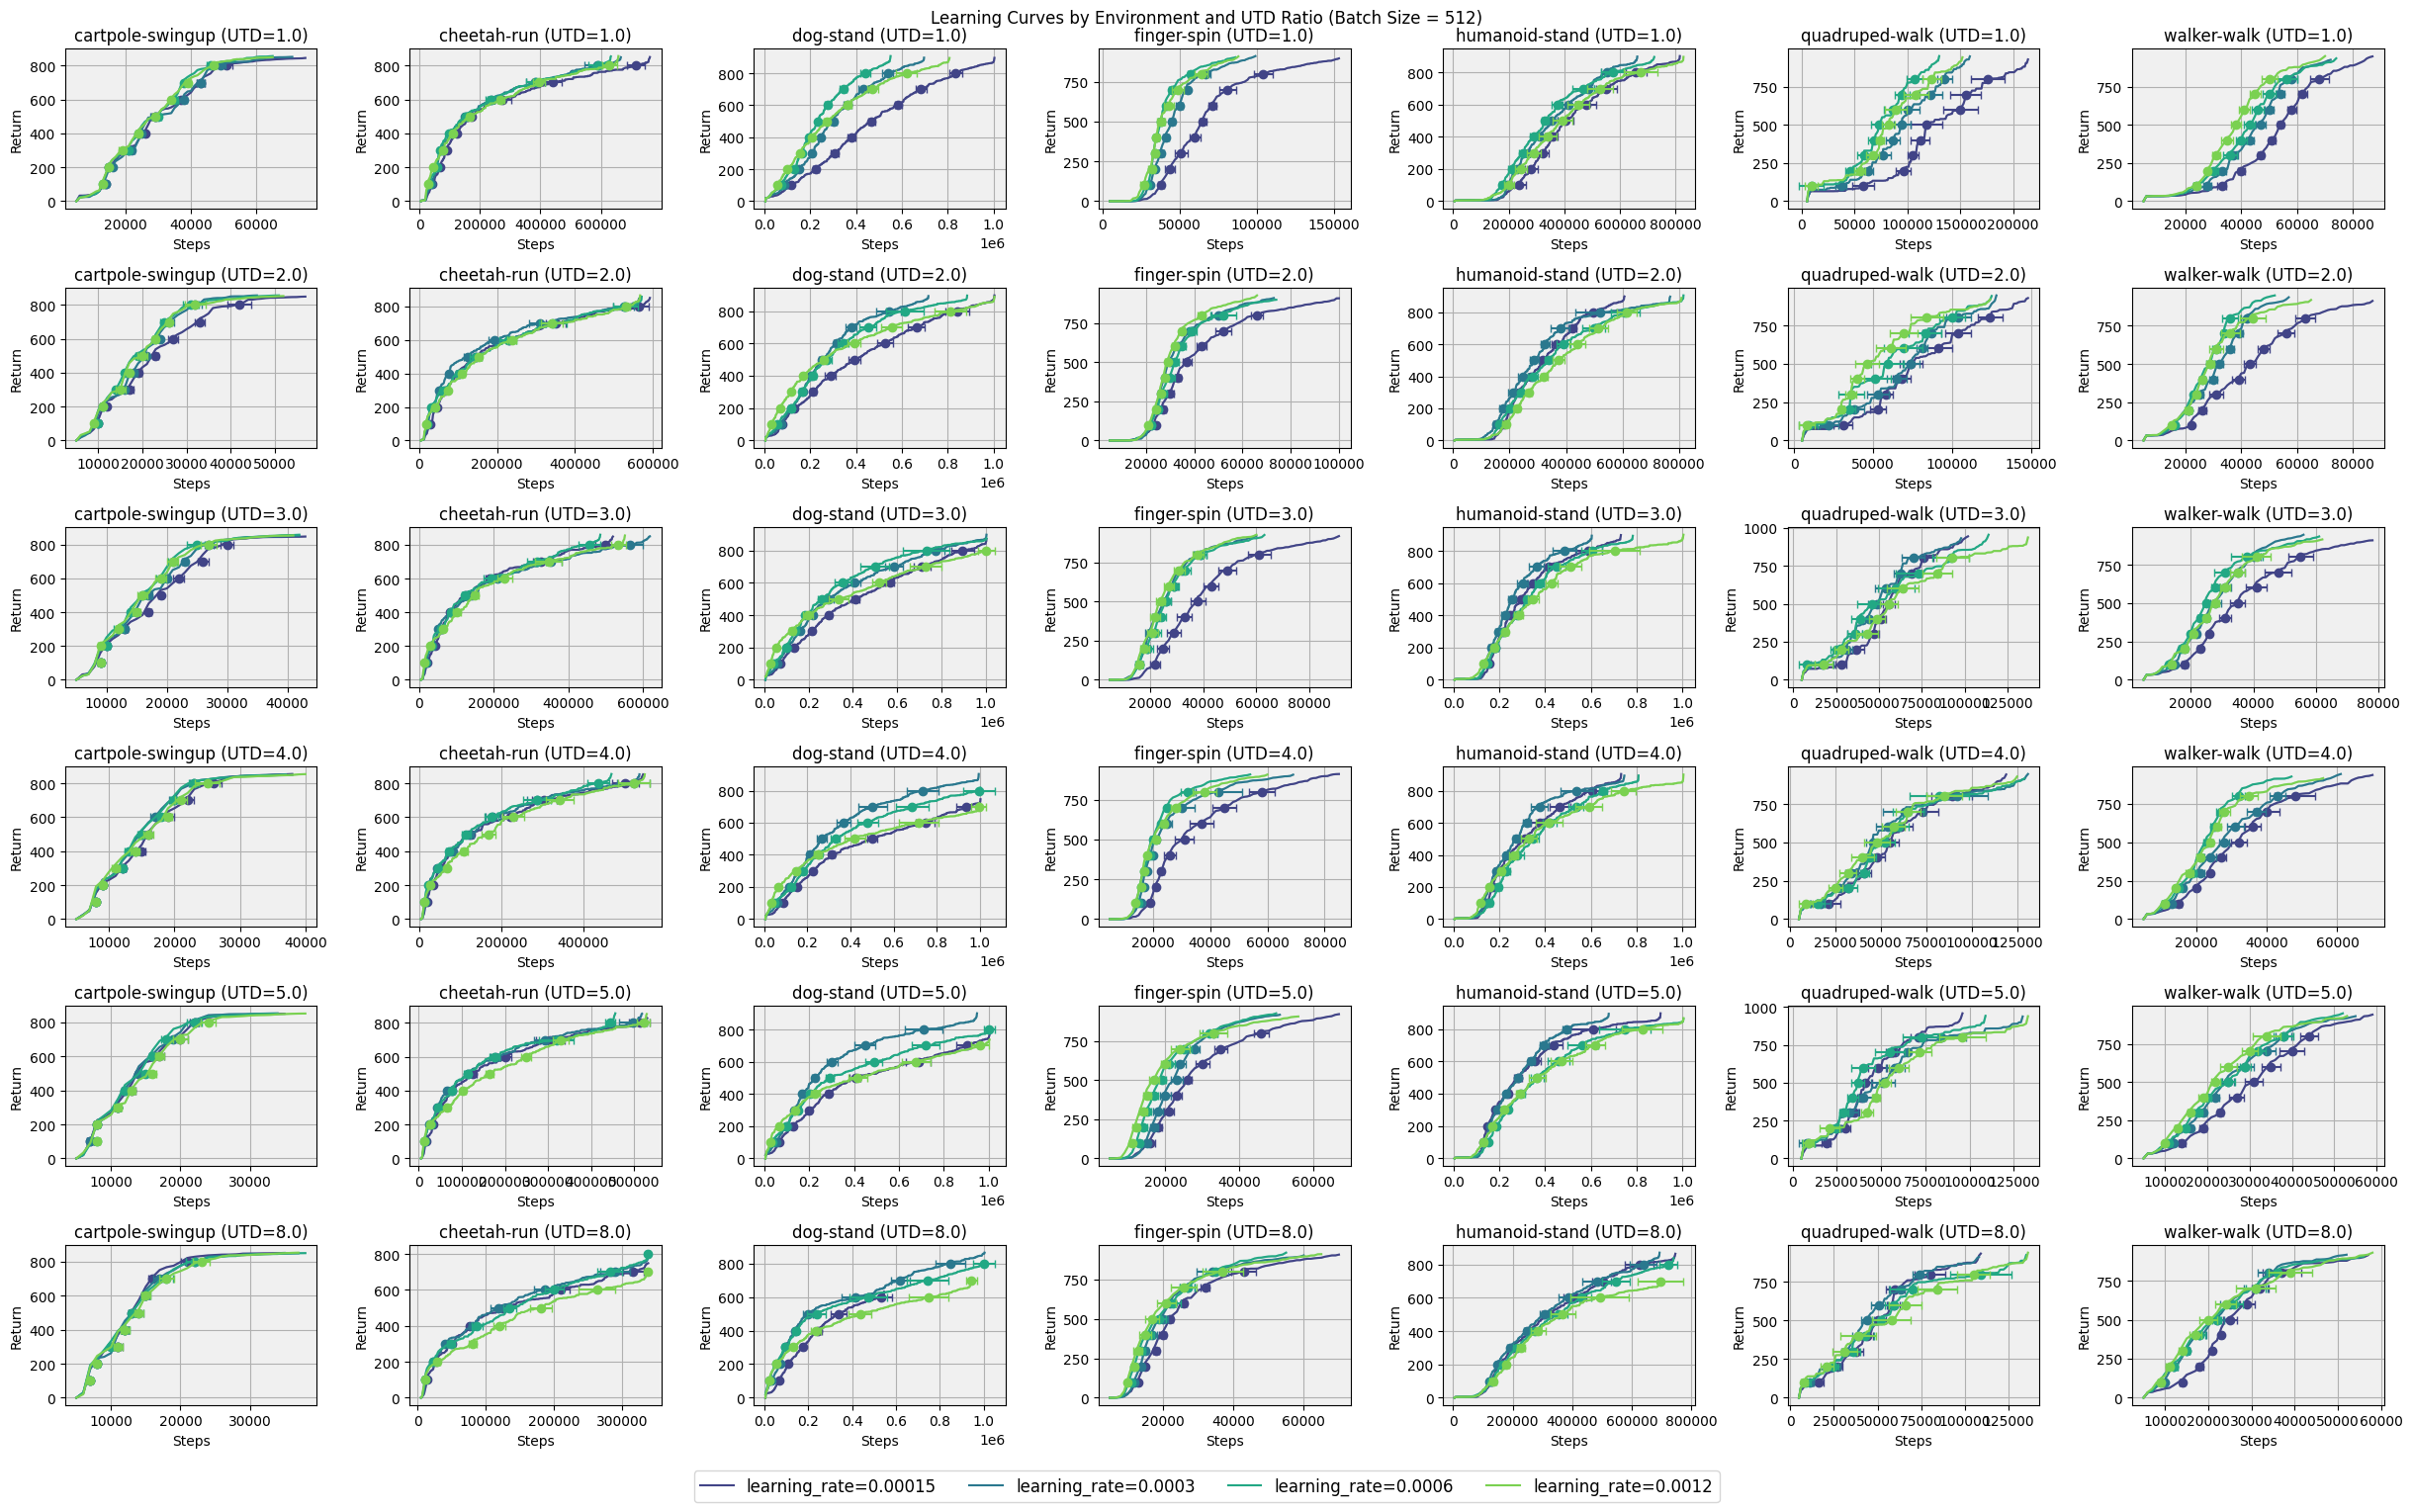

In [6]:
learning_curves.plot_per_batch_size(grid_search_df, config.thresholds)

# Bootstrapping

In [7]:
df_best_lr = bootstrapping.grid_best_uncertainty_lr(grid_search_df, print_pivot=True)


Best learning_rate:
env_name   cartpole-swingup                                 cheetah-run                                 dog-stand                                 finger-spin                                 humanoid-stand                                 quadruped-walk                                 walker-walk                                
batch_size              32      64      128     256     512         32      64      128     256     512       32      64      128     256     512         32      64      128     256     512            32      64      128     256     512            32      64      128     256     512         32      64      128     256     512
utd                                                                                                                                                                                                                                                                                                                                

In [8]:
df_best_bs = bootstrapping.grid_best_uncertainty_bs(grid_search_df, print_pivot=True)


Best batch_size:
env_name      cartpole-swingup                         cheetah-run                         dog-stand                         finger-spin                         humanoid-stand                         quadruped-walk                         walker-walk                        
learning_rate          1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03   1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03        1.5e-04 3.0e-04 6.0e-04 1.2e-03        1.5e-04 3.0e-04 6.0e-04 1.2e-03     1.5e-04 3.0e-04 6.0e-04 1.2e-03
utd                                                                                                                                                                                                                                                                               
1.0e+00                    512     512     256      64         512     512     512     512       128     128     256     128         512     512     512     

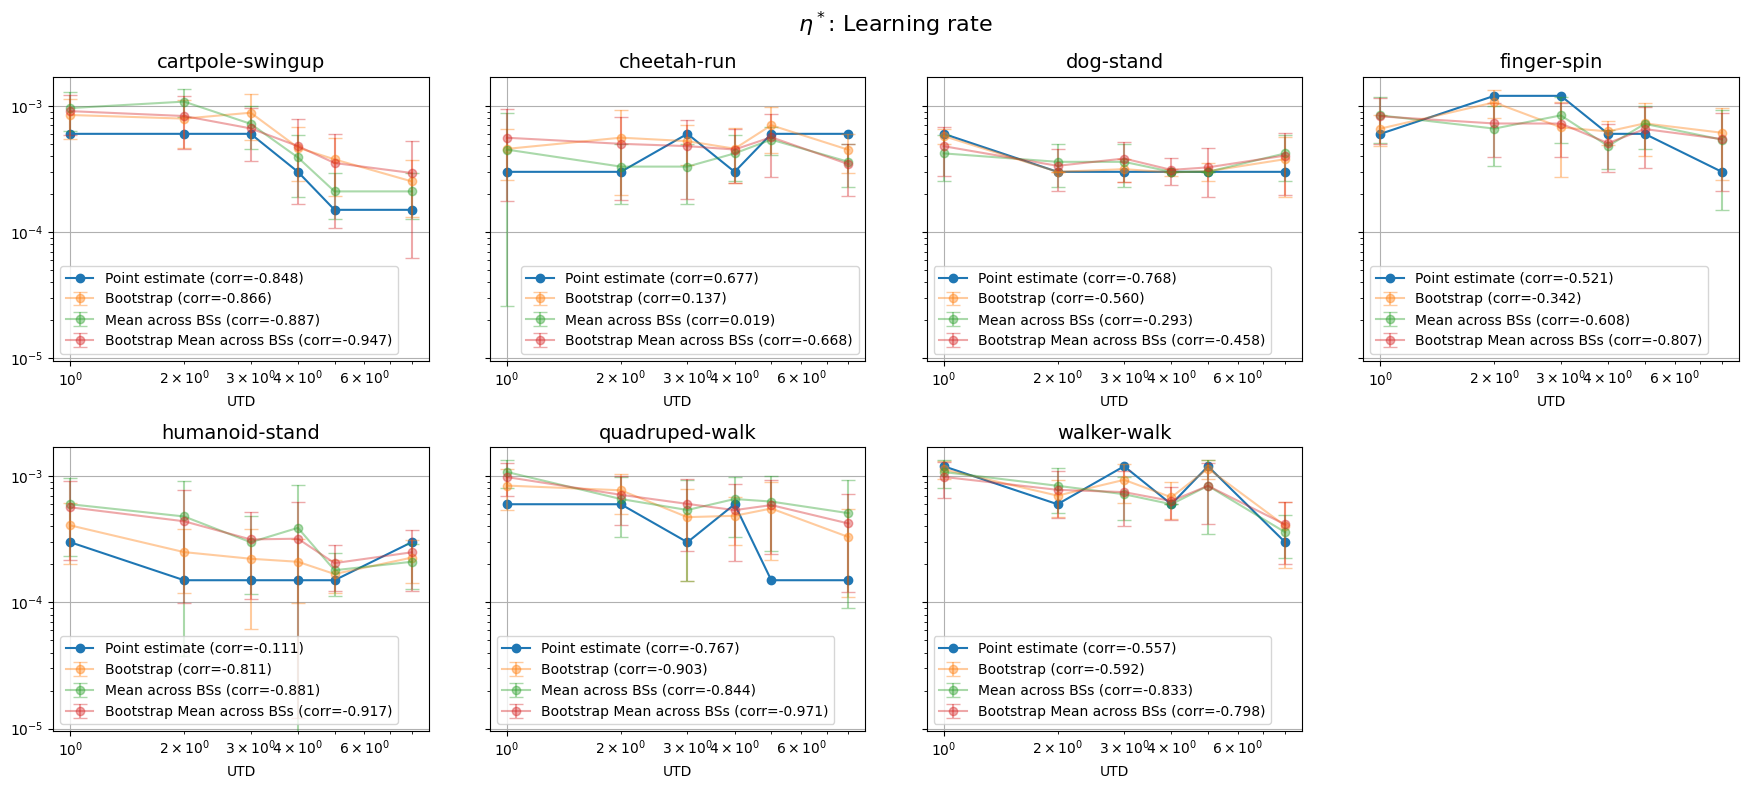

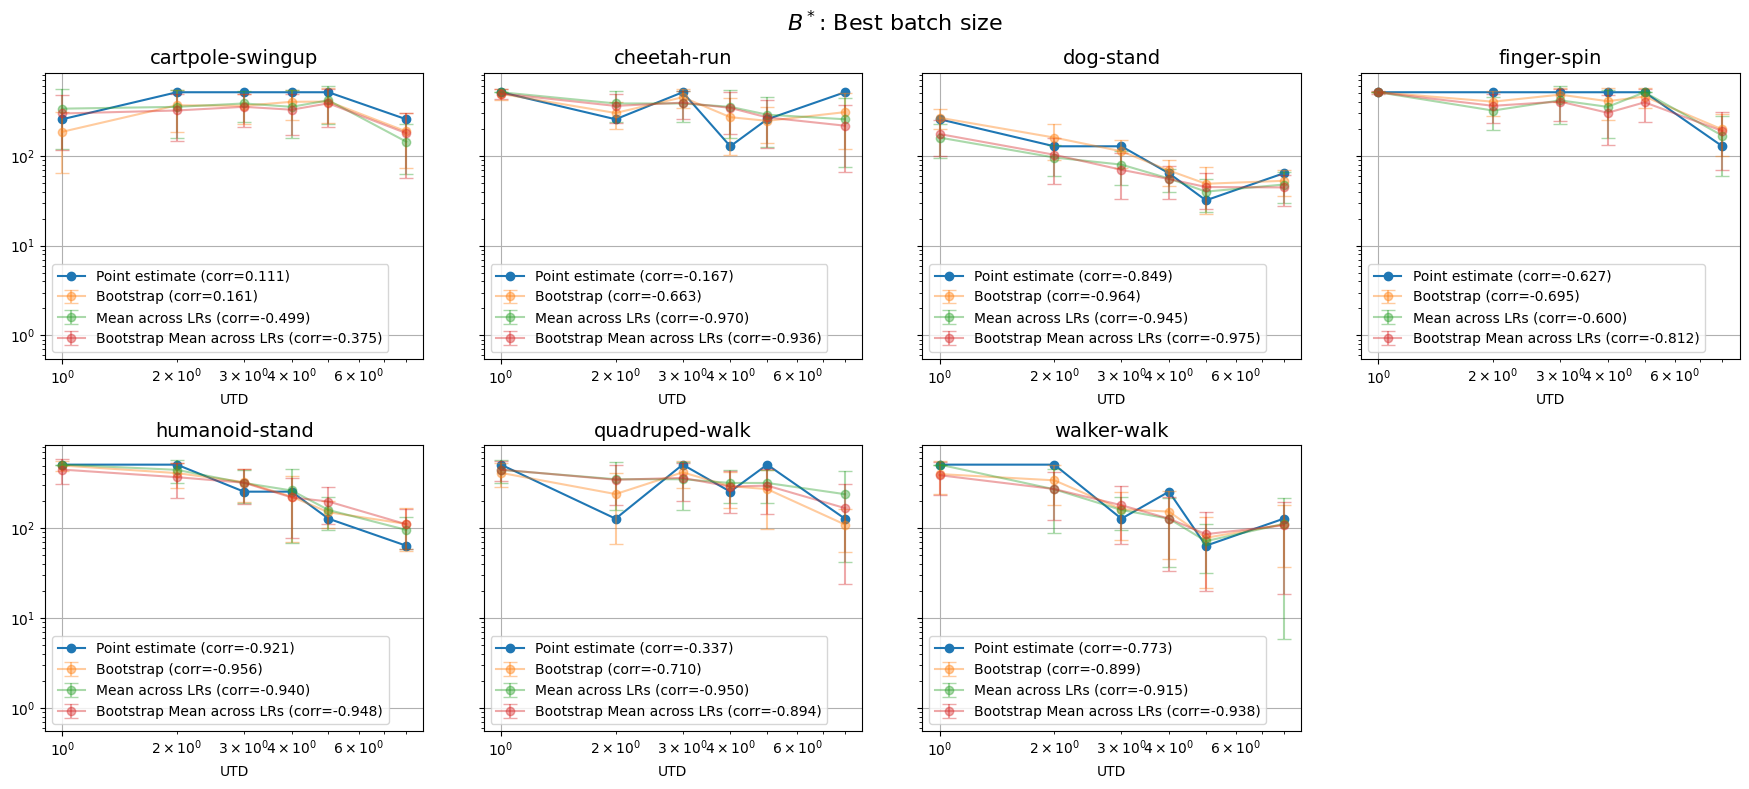

In [9]:
df_best_lr_bs = (
    df_best_lr.groupby(['env_name', 'utd'])
    .apply(bootstrapping.get_bootstrap_optimal, include_groups=False)
    .reset_index()
)
df_best_lr_bs = bootstrapping.compute_bootstrap_averages(
    df_best_lr, df_best_bs, df_best_lr_bs
)
bootstrapping.plot_bootstrap_average_params(df_best_lr_bs)

# Linear Fitting

Separate slope fits:
  cartpole-swingup:  learning rate ~ 0.001047 * UTD^-0.564172
  cheetah-run:       learning rate ~ 0.000533 * UTD^-0.048399
  dog-stand:         learning rate ~ 0.000452 * UTD^-0.231515
  finger-spin:       learning rate ~ 0.000832 * UTD^-0.213177
  humanoid-stand:    learning rate ~ 0.000603 * UTD^-0.572427
  quadruped-walk:    learning rate ~ 0.000942 * UTD^-0.356051
  walker-walk:       learning rate ~ 0.000928 * UTD^-0.167925

  cartpole-swingup:  batch size ~ 295.020220 * UTD^0.133250
  cheetah-run:       batch size ~ 491.749342 * UTD^-0.312694
  dog-stand:         batch size ~ 178.638784 * UTD^-0.847408
  finger-spin:       batch size ~ 473.082688 * UTD^-0.205294
  humanoid-stand:    batch size ~ 489.744011 * UTD^-0.517179
  quadruped-walk:    batch size ~ 442.851863 * UTD^-0.257123
  walker-walk:       batch size ~ 442.625235 * UTD^-0.914664

Saved separate slope fits to: ../outputs/grid_proposed_fits/dmc_sweep 



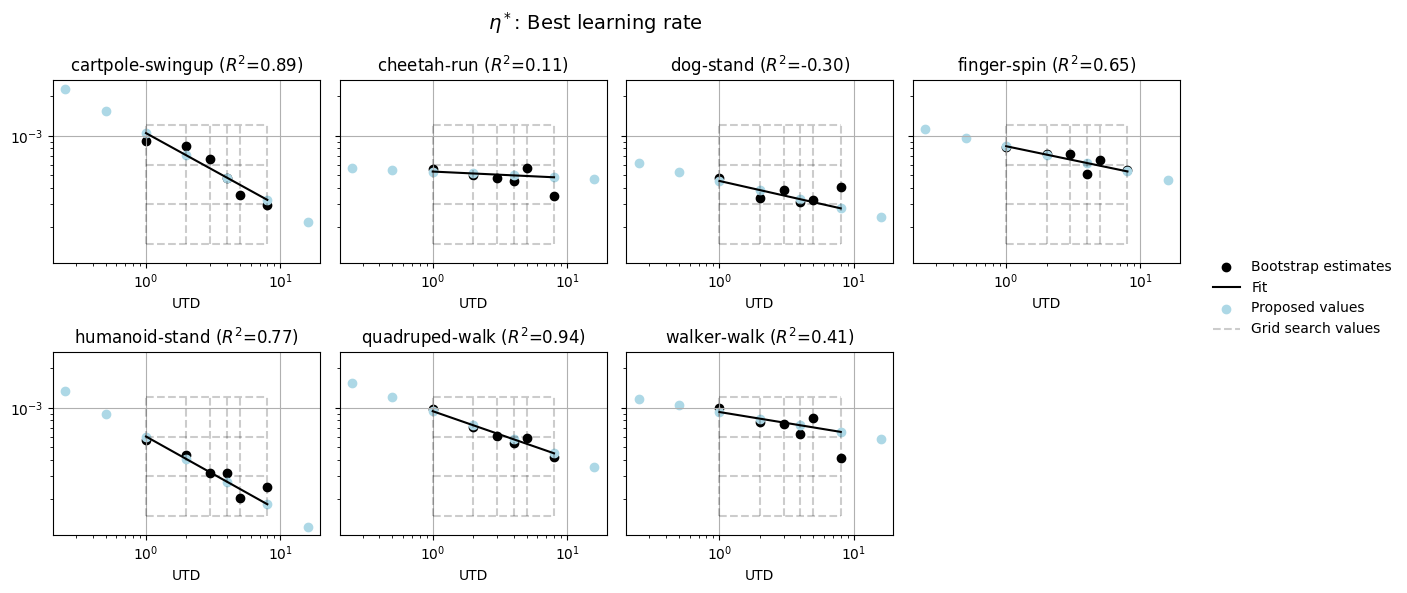

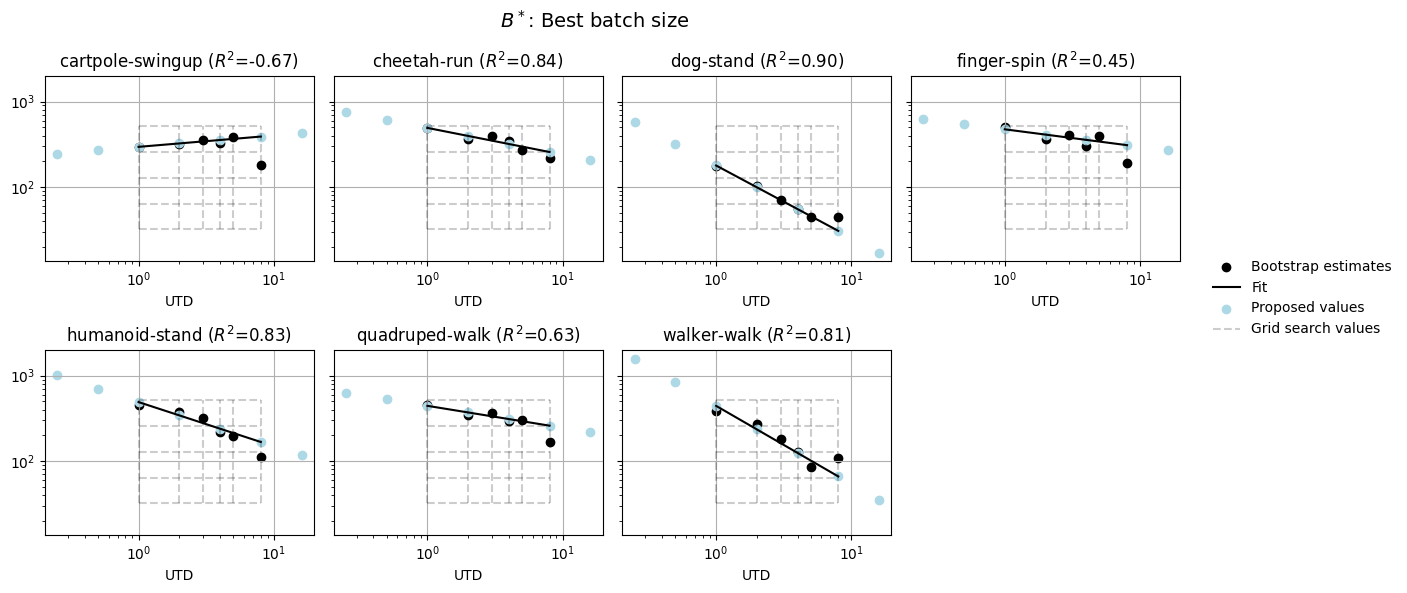

In [10]:
lr_regs_separate, bs_regs_separate = linear_fit.make_linear_fit_separate_slope(
    df_best_lr_bs, '../outputs', config.name
)
linear_fit.plot_fits_against_grid_separate_slope(
    grid_search_df, df_best_lr_bs, config.utds_to_predict, lr_regs_separate, bs_regs_separate
)

Shared slope fits:
  cartpole-swingup:  learning rate ~ 0.000779 * UTD^-0.320279
  cheetah-run:       learning rate ~ 0.000688 * UTD^-0.320279
  dog-stand:         learning rate ~ 0.000532 * UTD^-0.320279
  finger-spin:       learning rate ~ 0.000944 * UTD^-0.320279
  humanoid-stand:    learning rate ~ 0.000476 * UTD^-0.320279
  quadruped-walk:    learning rate ~ 0.000895 * UTD^-0.320279
  walker-walk:       learning rate ~ 0.001024 * UTD^-0.320279

  cartpole-swingup:  batch size ~ 527.833351 * UTD^-0.487930
  cheetah-run:       batch size ~ 584.433488 * UTD^-0.487930
  dog-stand:         batch size ~ 125.991537 * UTD^-0.487930
  finger-spin:       batch size ~ 602.706858 * UTD^-0.487930
  humanoid-stand:    batch size ~ 442.391871 * UTD^-0.487930
  quadruped-walk:    batch size ~ 536.399444 * UTD^-0.487930
  walker-walk:       batch size ~ 294.816789 * UTD^-0.487930

Saved shared slope fits to: ../outputs/grid_proposed_fits/dmc_sweep 



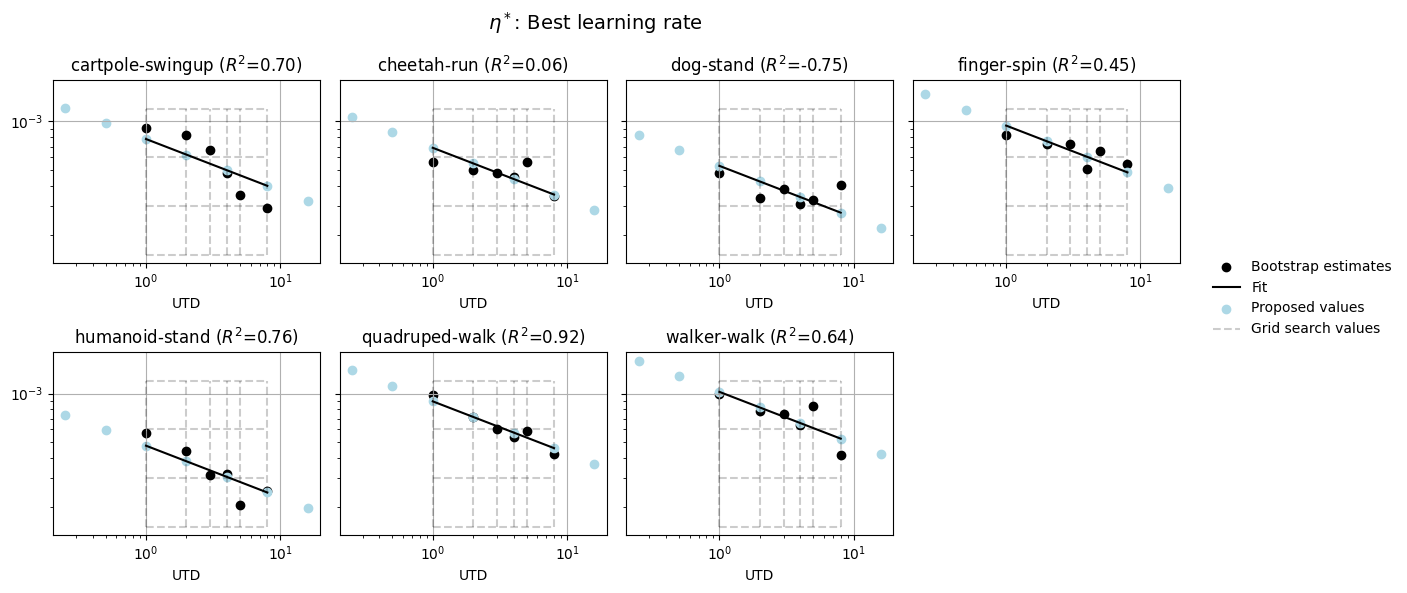

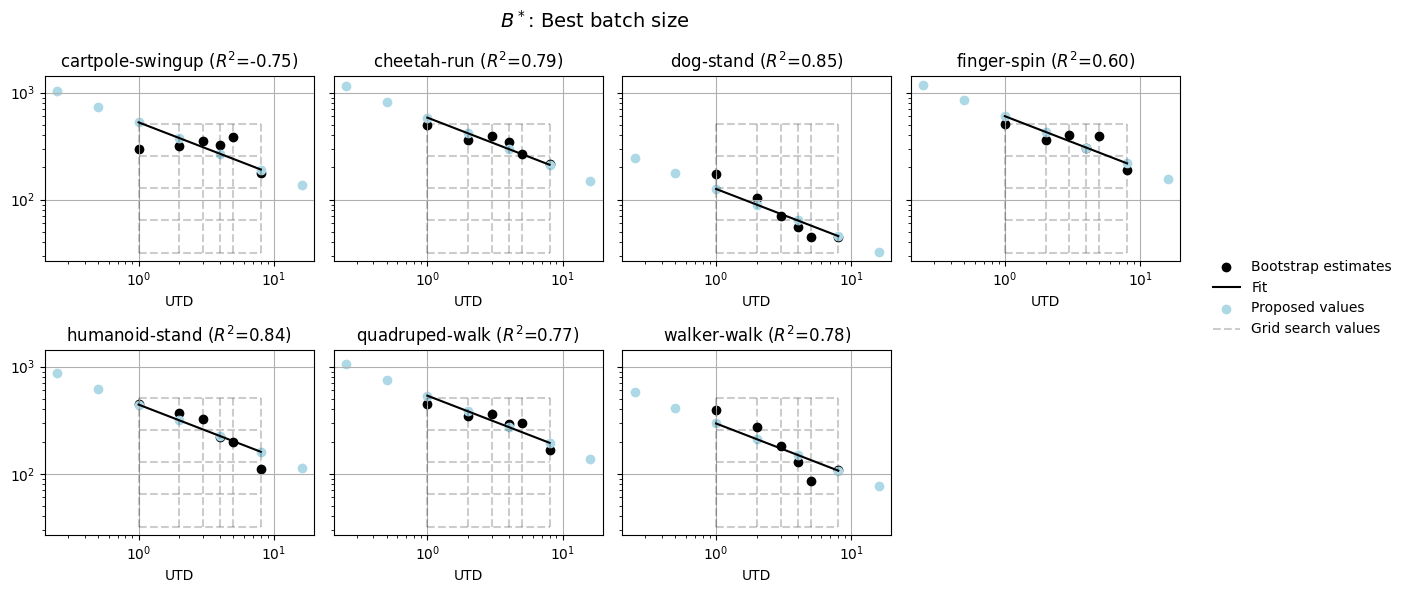

In [11]:
lr_reg_shared, bs_reg_shared = linear_fit.make_linear_fit_shared_slope(
    df_best_lr_bs, '../outputs', config.name
)
linear_fit.plot_fits_against_grid_shared_slope(
    grid_search_df, df_best_lr_bs, config.utds_to_predict, lr_reg_shared, bs_reg_shared
)

In [12]:
tabulate_kw = dict(
    df_grid=grid_search_df,
    utds_to_predict=config.utds_to_predict,
    outputs_dir='../outputs',
    save_path=config.name,
    verbose=False,
)

proposed_hparams_separate_slope = linear_fit.tabulate_proposed_hparams_separate_slope(
    lr_regs=lr_regs_separate, bs_regs=bs_regs_separate, **tabulate_kw
)
print('Separate slope:')
display(proposed_hparams_separate_slope)

proposed_hparams_shared_slope = linear_fit.tabulate_proposed_hparams_shared_slope(
    lr_reg_shared=lr_reg_shared, bs_reg_shared=bs_reg_shared, **tabulate_kw
)
print('Shared slope:')
display(proposed_hparams_shared_slope)

baseline_hparams = linear_fit.tabulate_baseline_hparams(**tabulate_kw)
print('Baseline:')
display(baseline_hparams)

Saved proposed hyperparameters to: ../outputs/grid_proposed_hparams/dmc_sweep/separate_fitted.csv 

Separate slope:


Environment     UTD  Learning Rate  Batch Size  Learning Rate x√2  \
0   cartpole-swingup 2.5e-01        2.3e-03         245            3.2e-03   
1   cartpole-swingup 5.0e-01        1.5e-03         268            2.2e-03   
2   cartpole-swingup 1.0e+00        1.0e-03         295            1.5e-03   
3   cartpole-swingup 2.0e+00        7.1e-04         323            1.0e-03   
4   cartpole-swingup 4.0e+00        4.8e-04         354            6.8e-04   
5   cartpole-swingup 8.0e+00        3.2e-04         389            4.6e-04   
6   cartpole-swingup 1.6e+01        2.2e-04         426            3.1e-04   
7        cheetah-run 2.5e-01        5.7e-04         758            8.1e-04   
8        cheetah-run 5.0e-01        5.5e-04         610            7.8e-04   
9        cheetah-run 1.0e+00        5.3e-04         491            7.5e-04   
10       cheetah-run 2.0e+00        5.2e-04         395            7.3e-04   
11       cheetah-run 4.0e+00        5.0e-04         318            7.1e-04   
12       cheetah-run 8.0e+00        4.8e-04         256            6.8e-04   
13       cheetah-run 1.6e+01        4.7e-04         206            6.6e-04   
14         dog-stand 2.5e-01        6.2e-04         578            8.8e-04   
15         dog-stand 5.0e-01        5.3e-04         321            7.5e-04   
16         dog-stand 1.0e+00        4.5e-04         178            6.4e-04   
17         dog-stand 2.0e+00        3.8e-04          99            5.4e-04   
18         dog-stand 4.0e+00        3.3e-04          55            4.6e-04   
19         dog-stand 8.0e+00        2.8e-04          30            4.0e-04   
20         dog-stand 1.6e+01        2.4e-04          17            3.4e-04   
21       finger-spin 2.5e-01        1.1e-03         628            1.6e-03   
22       finger-spin 5.0e-01        9.6e-04         545            1.4e-03   
23       finger-spin 1.0e+00        8.3e-04         473            1.2e-03   
24       finger-spin 2.0e+00        7.2e-04         410            1.0e-03   
25       finger-spin 4.0e+00        6.2e-04         355            8.8e-04   
26       finger-spin 8.0e+00        5.3e-04         308            7.6e-04   
27       finger-spin 1.6e+01        4.6e-04         267            6.5e-04   
28    humanoid-stand 2.5e-01        1.3e-03        1003            1.9e-03   
29    humanoid-stand 5.0e-01        9.0e-04         700            1.3e-03   
30    humanoid-stand 1.0e+00        6.0e-04         489            8.5e-04   
31    humanoid-stand 2.0e+00        4.1e-04         342            5.7e-04   
32    humanoid-stand 4.0e+00        2.7e-04         239            3.9e-04   
33    humanoid-stand 8.0e+00        1.8e-04         167            2.6e-04   
34    humanoid-stand 1.6e+01        1.2e-04         116            1.7e-04   
35    quadruped-walk 2.5e-01        1.5e-03         632            2.2e-03   
36    quadruped-walk 5.0e-01        1.2e-03         529            1.7e-03   
37    quadruped-walk 1.0e+00        9.4e-04         442            1.3e-03   
38    quadruped-walk 2.0e+00        7.4e-04         370            1.0e-03   
39    quadruped-walk 4.0e+00        5.7e-04         310            8.1e-04   
40    quadruped-walk 8.0e+00        4.5e-04         259            6.4e-04   
41    quadruped-walk 1.6e+01        3.5e-04         217            5.0e-04   
42       walker-walk 2.5e-01        1.2e-03        1572            1.7e-03   
43       walker-walk 5.0e-01        1.0e-03         834            1.5e-03   
44       walker-walk 1.0e+00        9.3e-04         442            1.3e-03   
45       walker-walk 2.0e+00        8.3e-04         234            1.2e-03   
46       walker-walk 4.0e+00        7.3e-04         124            1.0e-03   
47       walker-walk 8.0e+00        6.5e-04          66            9.3e-04   
48       walker-walk 1.6e+01        5.8e-04          35            8.2e-04   

    Learning Rate x√0.5  Batch Size x√2  Batch Size x√0.5  \
0               1.6e-03             346        

Saved proposed hyperparameters to: ../outputs/grid_proposed_hparams/dmc_sweep/shared_fitted.csv 

Shared slope:


Environment     UTD  Learning Rate  Batch Size  Learning Rate x√2  \
0   cartpole-swingup 2.5e-01        1.2e-03        1038            1.7e-03   
1   cartpole-swingup 5.0e-01        9.7e-04         740            1.4e-03   
2   cartpole-swingup 1.0e+00        7.8e-04         527            1.1e-03   
3   cartpole-swingup 2.0e+00        6.2e-04         376            8.8e-04   
4   cartpole-swingup 4.0e+00        5.0e-04         268            7.1e-04   
5   cartpole-swingup 8.0e+00        4.0e-04         191            5.7e-04   
6   cartpole-swingup 1.6e+01        3.2e-04         136            4.5e-04   
7        cheetah-run 2.5e-01        1.1e-03        1149            1.5e-03   
8        cheetah-run 5.0e-01        8.6e-04         819            1.2e-03   
9        cheetah-run 1.0e+00        6.9e-04         584            9.7e-04   
10       cheetah-run 2.0e+00        5.5e-04         416            7.8e-04   
11       cheetah-run 4.0e+00        4.4e-04         297            6.2e-04   
12       cheetah-run 8.0e+00        3.5e-04         211            5.0e-04   
13       cheetah-run 1.6e+01        2.8e-04         151            4.0e-04   
14         dog-stand 2.5e-01        8.3e-04         247            1.2e-03   
15         dog-stand 5.0e-01        6.6e-04         176            9.4e-04   
16         dog-stand 1.0e+00        5.3e-04         125            7.5e-04   
17         dog-stand 2.0e+00        4.3e-04          89            6.0e-04   
18         dog-stand 4.0e+00        3.4e-04          64            4.8e-04   
19         dog-stand 8.0e+00        2.7e-04          45            3.9e-04   
20         dog-stand 1.6e+01        2.2e-04          32            3.1e-04   
21       finger-spin 2.5e-01        1.5e-03        1185            2.1e-03   
22       finger-spin 5.0e-01        1.2e-03         845            1.7e-03   
23       finger-spin 1.0e+00        9.4e-04         602            1.3e-03   
24       finger-spin 2.0e+00        7.6e-04         429            1.1e-03   
25       finger-spin 4.0e+00        6.0e-04         306            8.6e-04   
26       finger-spin 8.0e+00        4.9e-04         218            6.9e-04   
27       finger-spin 1.6e+01        3.9e-04         155            5.5e-04   
28    humanoid-stand 2.5e-01        7.4e-04         870            1.0e-03   
29    humanoid-stand 5.0e-01        5.9e-04         620            8.4e-04   
30    humanoid-stand 1.0e+00        4.8e-04         442            6.7e-04   
31    humanoid-stand 2.0e+00        3.8e-04         315            5.4e-04   
32    humanoid-stand 4.0e+00        3.0e-04         224            4.3e-04   
33    humanoid-stand 8.0e+00        2.4e-04         160            3.5e-04   
34    humanoid-stand 1.6e+01        2.0e-04         114            2.8e-04   
35    quadruped-walk 2.5e-01        1.4e-03        1054            2.0e-03   
36    quadruped-walk 5.0e-01        1.1e-03         752            1.6e-03   
37    quadruped-walk 1.0e+00        8.9e-04         536            1.3e-03   
38    quadruped-walk 2.0e+00        7.2e-04         382            1.0e-03   
39    quadruped-walk 4.0e+00        5.7e-04         272            8.1e-04   
40    quadruped-walk 8.0e+00        4.6e-04         194            6.5e-04   
41    quadruped-walk 1.6e+01        3.7e-04         138            5.2e-04   
42       walker-walk 2.5e-01        1.6e-03         579            2.3e-03   
43       walker-walk 5.0e-01        1.3e-03         413            1.8e-03   
44       walker-walk 1.0e+00        1.0e-03         294            1.4e-03   
45       walker-walk 2.0e+00        8.2e-04         210            1.2e-03   
46       walker-walk 4.0e+00        6.6e-04         149            9.3e-04   
47       walker-walk 8.0e+00        5.3e-04         106            7.4e-04   
48       walker-walk 1.6e+01        4.2e-04          76            6.0e-04   

    Learning Rate x√0.5  Batch Size x√2  Batch Size x√0.5  \
0               8.6e-04            1468        

Baseline based optimal hyperparamers at UTD 2.0 

Saved baseline hyperparameters to: ../outputs/grid_proposed_hparams/dmc_sweep/baseline_utd2.0.csv 

Baseline:


Environment     UTD  Learning Rate  Batch Size  is_new_experiment
0   cartpole-swingup 2.5e-01        6.0e-04         512               True
1   cartpole-swingup 5.0e-01        6.0e-04         512               True
2   cartpole-swingup       1        6.0e-04         512              False
3   cartpole-swingup       2        6.0e-04         512              False
4   cartpole-swingup       4        6.0e-04         512              False
5   cartpole-swingup       8        6.0e-04         512              False
6   cartpole-swingup      16        6.0e-04         512               True
7        cheetah-run 2.5e-01        3.0e-04         256               True
8        cheetah-run 5.0e-01        3.0e-04         256               True
9        cheetah-run       1        3.0e-04         256              False
10       cheetah-run       2        3.0e-04         256              False
11       cheetah-run       4        3.0e-04         256              False
12       cheetah-run       8        3.0e-04         256              False
13       cheetah-run      16        3.0e-04         256               True
14         dog-stand 2.5e-01        3.0e-04         128               True
15         dog-stand 5.0e-01        3.0e-04         128               True
16         dog-stand       1        3.0e-04         128              False
17         dog-stand       2        3.0e-04         128              False
18         dog-stand       4        3.0e-04         128              False
19         dog-stand       8        3.0e-04         128              False
20         dog-stand      16        3.0e-04         128               True
21       finger-spin 2.5e-01        1.2e-03         512               True
22       finger-spin 5.0e-01        1.2e-03         512               True
23       finger-spin       1        1.2e-03         512              False
24       finger-spin       2        1.2e-03         512              False
25       finger-spin       4        1.2e-03         512              False
26       finger-spin       8        1.2e-03         512              False
27       finger-spin      16        1.2e-03         512               True
28    humanoid-stand 2.5e-01        1.5e-04         512               True
29    humanoid-stand 5.0e-01        1.5e-04         512               True
30    humanoid-stand       1        1.5e-04         512              False
31    humanoid-stand       2        1.5e-04         512              False
32    humanoid-stand       4        1.5e-04         512              False
33    humanoid-stand       8        1.5e-04         512              False
34    humanoid-stand      16        1.5e-04         512               True
35    quadruped-walk 2.5e-01        6.0e-04         128               True
36    quadruped-walk 5.0e-01        6.0e-04         128               True
37    quadruped-walk       1        6.0e-04         128              False
38    quadruped-walk       2        6.0e-04         128              False
39    quadruped-walk       4        6.0e-04         128              False
40    quadruped-walk       8        6.0e-04         128              False
41    quadruped-walk      16        6.0e-04         128               True
42       walker-walk 2.5e-01        6.0e-04         512               True
43       walker-walk 5.0e-01        6.0e-04         512               True
44       walker-walk       1        6.0e-04         512              False
45       walker-walk       2        6.0e-04         512              False
46       walker-walk       4        6.0e-04         512              False
47       walker-walk       8        6.0e-04         512              False
48       walker-walk      16        6.0e-04         512               True

# Data Efficiency

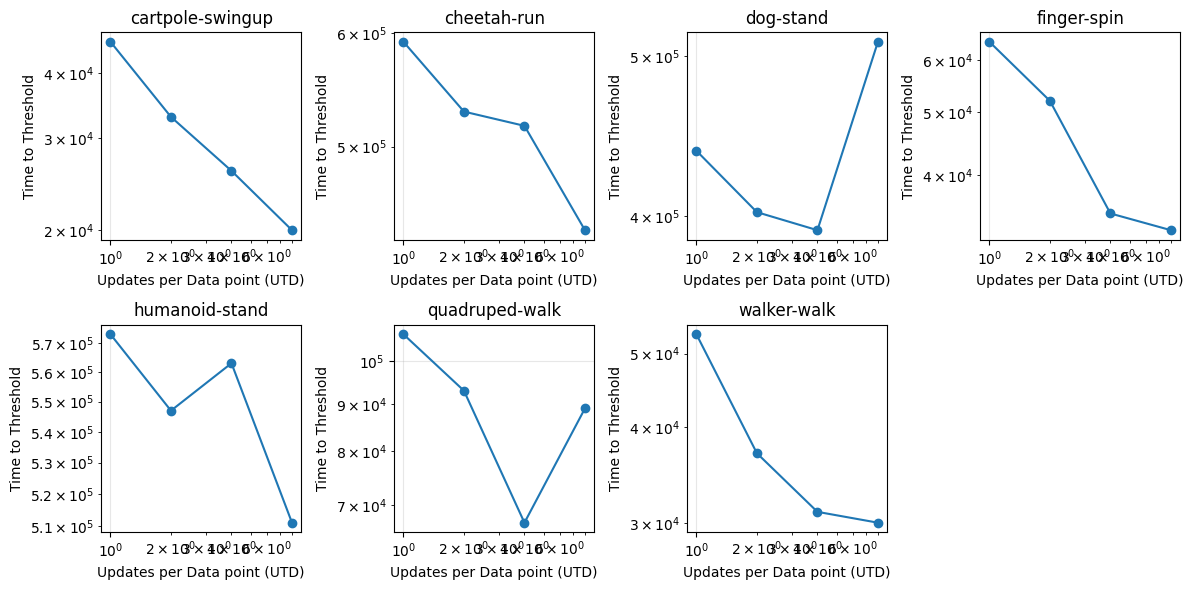

In [13]:
closest_fit_steps_per_utd = data_efficiency.plot_closest_data_efficiency(
    grid_search_df, proposed_hparams_shared_slope
)

/home/preston/value-scaling-workflow-private/qscaled/utils/power_law.py:6: RuntimeWarning: invalid value encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/value-scaling-workflow-private/qscaled/utils/power_law.py:6: RuntimeWarning: overflow encountered in power
  return c + (x / (b + 1e-12)) ** (-a)
/home/preston/miniconda3/envs/value-scaling/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


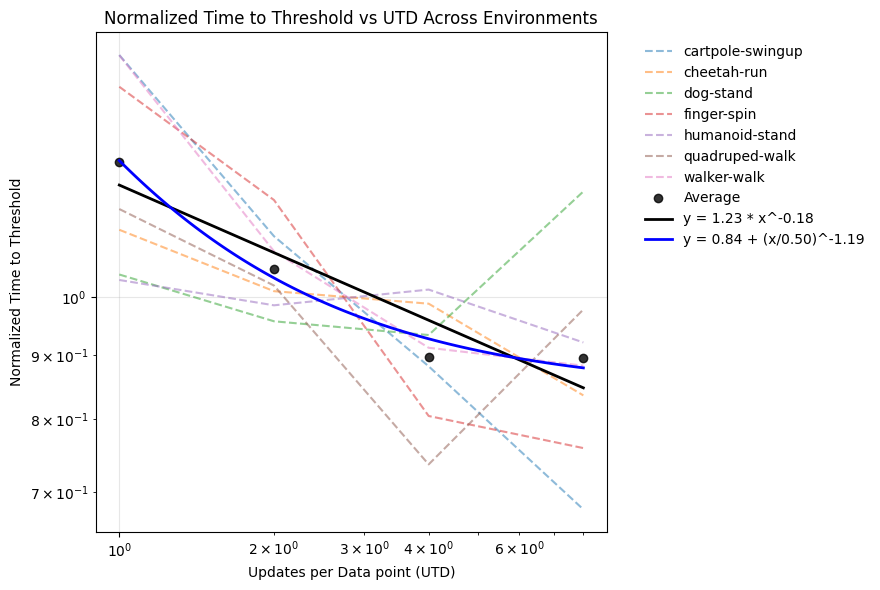

In [14]:
data_efficiency.plot_averaged_data_efficiency(closest_fit_steps_per_utd)